## NEURAL NETWORKS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scienceplots

plt.style.use('ieee')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
plt.rcParams.update({'figure.dpi': 300}) 
plt.rcParams['font.size'] = 8  

In [290]:
def activate(activations, selected_function = "none"):

    if selected_function == "none":
        return activations
    elif selected_function == "relu" :
        return np.where(activations > 0, activations, 0)
    elif selected_function == "leaky_relu":
        return np.where(activations > 0, activations, 0.01 * activations)
    elif selected_function == "gelu":
        return activations*(activate(1.702*activations, selected_function="sigmoid"))
    elif selected_function == "sigmoid":
        return 1 / (1 + np.e ** (-activations))
    else:
        raise ValueError(f"An unknown selection function \"{selected_function}\" was choosen.")

In [291]:
def d_activate(activations, selected_function = "none"):
    if selected_function == "none":
        return np.ones(shape=activations.shape)
    elif selected_function == "relu":
        return np.where(activations > 0, 1, 0) 
    elif selected_function == "leaky_relu":
        return np.where(activations > 0, 1, 0.01)
    elif selected_function == "gelu":
        return activate(1.702*activations, "sigmoid") * (1 + 1.702*activations*(1 - activate(1.702*activations, "sigmoid")))
    elif selected_function == "sigmoid" :
        sigmoid_of_x = activate(activations, selected_function="sigmoid")
        return sigmoid_of_x * (1 - sigmoid_of_x)

In [292]:
def softmax(activations):
    exp_arr = np.exp(activations - np.max(activations))
    row_sums = np.sum(exp_arr, axis=1, keepdims=True) 
    row_sums_safe = np.where(row_sums == 0, 1e-10, row_sums)
    probabilities = exp_arr / row_sums_safe
    return probabilities

In [535]:
def MSE_loss(y_hat, y):
    loss = np.mean((y_hat-y)**2) 
    return loss

def log_loss(y_hat, y): 
    y_hat = softmax(y_hat)
    y_hat_safe = np.where(y_hat == 0, 1e-42, y_hat)
    loss = -np.mean(np.sum(y*np.log(y_hat_safe), axis=1)) 
    return loss 

def MAE_loss(y_hat, y):
    loss = np.mean(np.abs(y_hat - y))
    return loss

def Huber_loss(y_hat, y, delta=0.1):
    error = y_hat - y
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error**2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    loss = np.where(is_small_error, squared_loss, linear_loss)
    return np.mean(loss)

def log_cosh_loss(y_hat, y):
    loss = np.mean(np.log(np.cosh(y_hat - y)))
    return loss

def quantile_loss(y_hat, y, quantile=0.55):
    error = y_hat - y
    loss = np.where(error >= 0, quantile * error, (quantile - 1) * error)
    return np.mean(loss)

def weighted_loss(y_hat, y, spike_threshold=0.1, spike_weight=5.0):
    error = y_hat - y
    loss = np.where(np.abs(error) > spike_threshold, spike_weight * np.abs(error), np.abs(error))
    return np.mean(loss)

In [294]:
def d_MSE_loss(y_hat, y):
    n = y.shape[0]
    dy = 2*(y_hat-y) / n
    return dy

def d_log_loss(y_hat, y):
    y_hat = softmax(y_hat)
    return (y_hat - y) / y.shape[0]

def d_MAE_loss(y_hat, y):
    n = y.shape[0]
    dy = np.sign(y_hat - y) / n
    return dy

def d_Huber_loss(y_hat, y, delta=0.1):
    error = y_hat - y
    is_small_error = np.abs(error) <= delta
    dy = np.where(is_small_error, error, delta * np.sign(error)) / y.shape[0]
    return dy

def d_log_cosh_loss(y_hat, y):
    return np.tanh(y_hat - y) / y.shape[0]

def d_quantile_loss(y_hat, y, quantile=0.55):
    error = y_hat - y
    dy = np.where(error >= 0, quantile, quantile - 1) / y.shape[0]
    return dy

def d_weighted_loss(y_hat, y, spike_threshold=0.1, spike_weight=5.0):
    error = y_hat - y
    dy = np.where(np.abs(error) > spike_threshold, spike_weight * np.sign(error), np.sign(error)) / y.shape[0]
    return dy

In [295]:
def propagate_forward(weights, activations_prev, bias, activation_function="none"):
    logits = np.dot(activations_prev, weights) + bias 
    new_activations = activate(logits, activation_function)
    return new_activations

In [296]:
def propagate_backward(weights, activations_prev, dl_dz, bias, activation_function="none"):
    dot_product = np.dot(activations_prev, weights)
    dz_df = d_activate(dot_product + bias, activation_function)

    df_dw = activations_prev

    delta = dl_dz * dz_df
    d_weights = np.dot(np.transpose(df_dw), delta)

    df_db = np.ones(shape=delta.shape) # unecessary op for clarity purposes, d/db(xw + b) = 1
    d_bias = df_db * delta
    d_bias = np.sum(d_bias, axis=0)
    
    dl_dz = np.dot(delta, np.transpose(weights))
    
    return d_weights, d_bias, dl_dz

In [297]:
def weight_initialization(n_in, n_out, technique="he"):
    mean = 0
    if technique == "xavier":
        stddev = np.sqrt(2 / (n_in + n_out))
        weight_array = np.random.normal(mean,stddev,(n_in, n_out))
        return weight_array
    elif technique == "he":
        stddev = np.sqrt(2 / (n_in))
        weight_array = np.random.normal(mean,stddev,(n_in, n_out))
        return weight_array
    else:
        raise ValueError("Please, choose amongst \'xavier\' or \'he\' initialization")
    
def bias_initialization(n_out):
    return np.zeros(n_out)

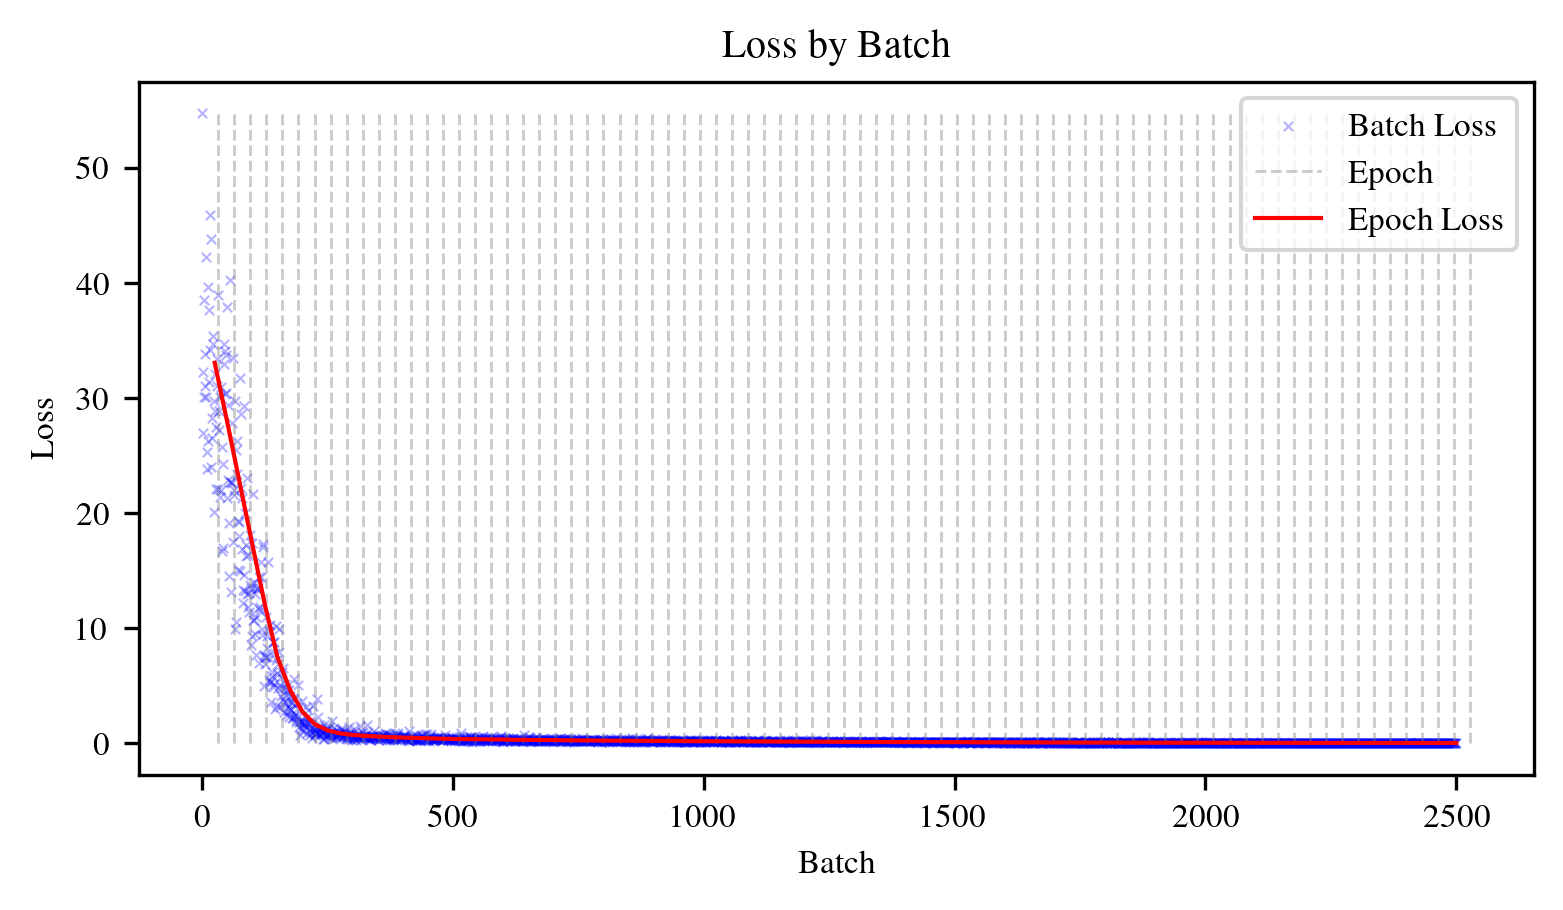

In [461]:
class Optimizer:
    def __init__(self, optimizer_type, lr, weight_shape, bias_shape, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.optimizer_type = optimizer_type
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0

        self.m_w, self.v_w = np.zeros(weight_shape), np.zeros(weight_shape)
        self.m_b, self.v_b = np.zeros(bias_shape), np.zeros(bias_shape)

    def update(self, weights, biases, d_weights, d_bias):
        self.t += 1
        if self.optimizer_type == 'sgd':
            weights -= self.lr * d_weights
            biases -= self.lr * d_bias
        elif self.optimizer_type == 'momentum':
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * d_weights
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * d_bias
            weights -= self.lr * self.m_w
            biases -= self.lr * self.m_b
        elif self.optimizer_type == 'adam':
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * d_weights
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (d_weights ** 2)
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * d_bias
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (d_bias ** 2)

            m_w_hat = self.m_w / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w / (1 - self.beta2 ** self.t)
            m_b_hat = self.m_b / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b / (1 - self.beta2 ** self.t)

            weights -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            biases -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

        return weights, biases

class NeuralNet(object):
    
    def __init__ (self, input_dim, output_dim, neurons = [], loss_function='mse', activation_function='relu', optimizer_type='adam', learning_rate=1e-3):
        n_ins  = [input_dim] + neurons 
        n_outs = neurons + [output_dim]

        self.weights = [weight_initialization(n_in, n_out) for n_in,n_out in zip(n_ins, n_outs)]
        self.biases = [bias_initialization(n_out) for n_out in n_outs]
        self.activation_functions = [activation_function] * len(neurons) + ["none"]

        loss_functions = {
            'log_loss': (log_loss, d_log_loss),
            'mse': (MSE_loss, d_MSE_loss),
            'mae': (MAE_loss, d_MAE_loss),
            'huber_loss': (Huber_loss, d_Huber_loss),
            'log_cosh_loss': (log_cosh_loss, d_log_cosh_loss),
            'quantile_loss': (quantile_loss, d_quantile_loss),
            'weighted_loss': (weighted_loss, d_weighted_loss)
        }
        self.loss, self.d_loss = loss_functions[loss_function]
        self.optimizers = [Optimizer(optimizer_type, learning_rate, w.shape, b.shape) for w, b in zip(self.weights, self.biases)]

    
    def forward(self, x):
        # TODO: Add support for a bias for each neuron in the code below.
        for layer_weights, layer_biases, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            x = propagate_forward(layer_weights, x, layer_biases, layer_activation_function)
        return x
    
    def adjust_weights(self, x, y):
                
        activation = x 
        activation_history = [] 
        
        for layer_weights, layer_biases, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            activation_history.append(activation)
            activation = propagate_forward(layer_weights, activation, layer_biases, layer_activation_function)
           
        loss = self.loss(activation,y)
        
        dl_dz = self.d_loss(activation,y) 

        for current_layer, (layer_weights, layer_biases, layer_activation_function, previous_activations) in reversed(list(enumerate(zip(self.weights, self.biases, self.activation_functions, activation_history)))):
            d_weights, d_bias, dl_dz = propagate_backward(layer_weights, previous_activations,  dl_dz, layer_biases, layer_activation_function)
            self.weights[current_layer], self.biases[current_layer] = self.optimizers[current_layer].update(
                layer_weights, layer_biases, d_weights, d_bias
            )
        return loss
    
    def train_net(self, X, y, batch_size=32, epochs=100, use_validation_data=False, validation_split=0.2, patience=5, decay_factor=0.5, decay_patience=5, min_lr=1e-6):
        losses = []
        best_val_loss = float('inf')
        avg_epoch_loss = []
        patience_counter = 0
        decay_counter = 0

        if use_validation_data:
            val_size = int(validation_split * X.shape[0])
            X_train, X_val = X[:-val_size], X[-val_size:]
            y_train, y_val = y[:-val_size], y[-val_size:]
        else:
            X_train, y_train = X, y
        
        for epoch in range(epochs):
            shuffled_indices = np.arange(X_train.shape[0])
            np.random.shuffle(shuffled_indices)
            X_train = X_train[shuffled_indices, :]
            y_train = y_train[shuffled_indices]
            batch_count = X_train.shape[0] // batch_size
            total_epoch_loss = 0
            
            for batch in range(batch_count):
                mini_batch = X_train[batch*batch_size:(batch+1)*batch_size, :]
                mini_y = y_train[batch*batch_size:(batch+1)*batch_size]
                loss = self.adjust_weights(mini_batch, mini_y)
                losses.append(loss)
                total_epoch_loss += loss
            
            mean_epoch_loss = total_epoch_loss / batch_count
            avg_epoch_loss.append(mean_epoch_loss)
            
            # if epoch % 5 == 0:
            # print(f'{epoch}. LOSS: {mean_epoch_loss}')
            
            if use_validation_data:
                val_predictions = self.forward(X_val)
                val_loss = self.loss(val_predictions, y_val)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    decay_counter = 0
                else:
                    patience_counter += 1
                    decay_counter += 1

                    if decay_counter >= decay_patience: 
                        new_learning_rate = max(learning_rate * decay_factor, min_lr)  
                        # print(f"Reducing learning rate from {learning_rate} to {new_learning_rate}")
                        self.learning_rate = new_learning_rate
                        decay_counter = 0 

                    if patience_counter >= patience:
                        # print(f"Early stopping at epoch {epoch+1} with validation loss {val_loss}")
                        return losses, avg_epoch_loss
        
        return losses, avg_epoch_loss

batch_size = 32
batch_count = 32
rows = batch_size * batch_count
features = 4
epochs = 100
v_s = 0.2
new_batches_by_epoch = int((rows * (1-v_s))/batch_size)

# y = k*X, 
# NN models 'k' 
k = np.random.randint(0,10,(features,1))
X = np.random.normal(0,1,(rows,features))
y = np.dot(X,k) + 0.1 + np.random.normal(0,0.01,(rows,1))
nn = NeuralNet(features, 1, [18, 12], activation_function='leaky_relu', optimizer_type='adam', learning_rate=1e-3, loss_function='mse')
losses_by_batch, losses_by_epoch = nn.train_net(X, y, batch_size=32, epochs=epochs, use_validation_data=True, validation_split=v_s)

plt.figure(figsize=(6, 3))   
plt.scatter(range(len(losses_by_batch)), losses_by_batch, marker='x', lw=.5, s=5, alpha=0.3, color='blue', zorder=1, label='Batch Loss')
plt.vlines(x=np.arange(0, len(losses_by_batch) + batch_size, batch_size)[1:], color='gray', linestyle='--', label=f'Epoch', alpha=0.4, ymin=0, ymax=np.max(losses_by_batch), lw=0.7)
plt.plot(np.arange(0, len(losses_by_epoch)*new_batches_by_epoch + new_batches_by_epoch, new_batches_by_epoch)[1:], losses_by_epoch, alpha=1, color='red', lw=1, zorder=2, label='Epoch Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss by Batch')
plt.legend()
plt.show()

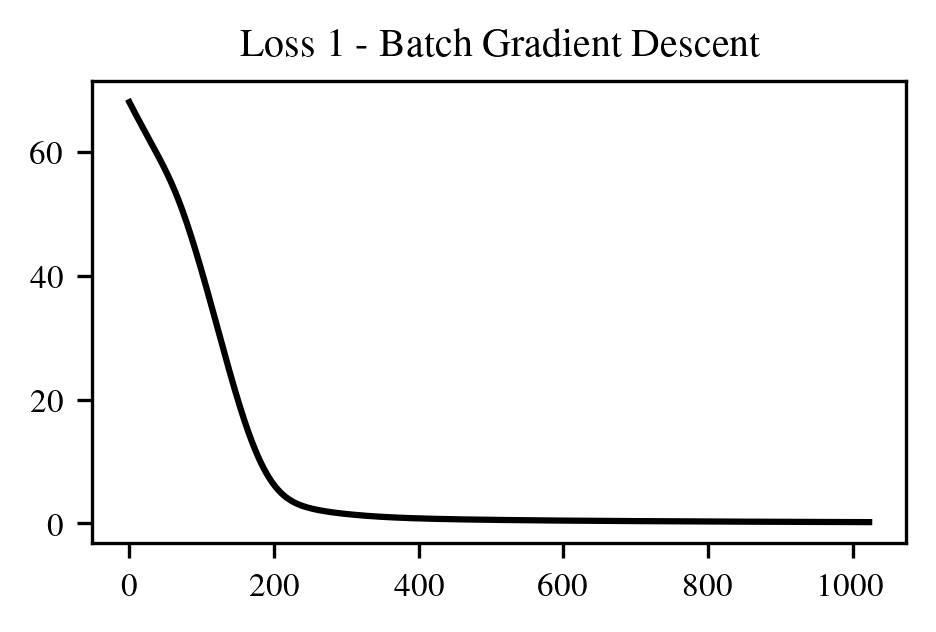

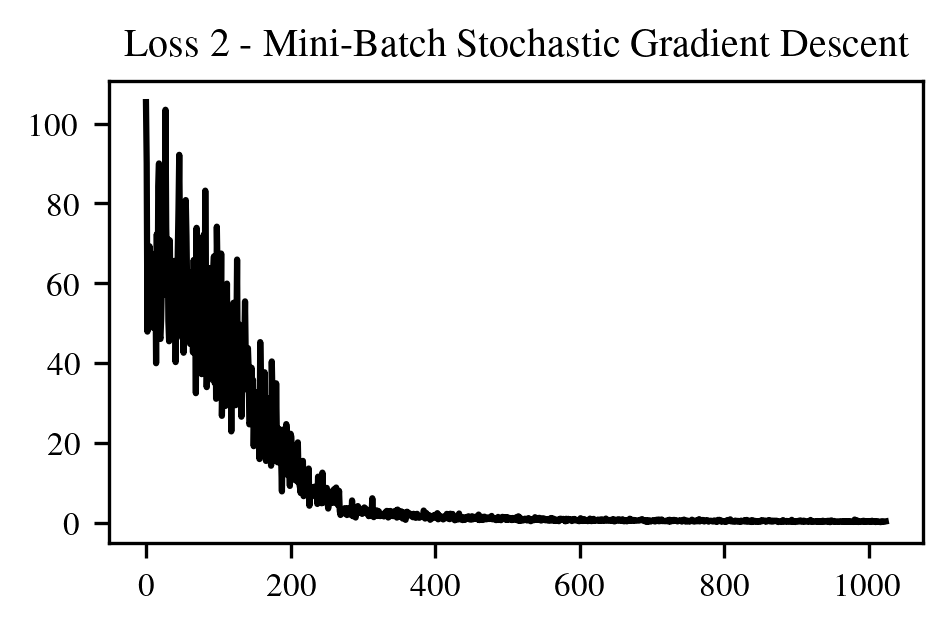

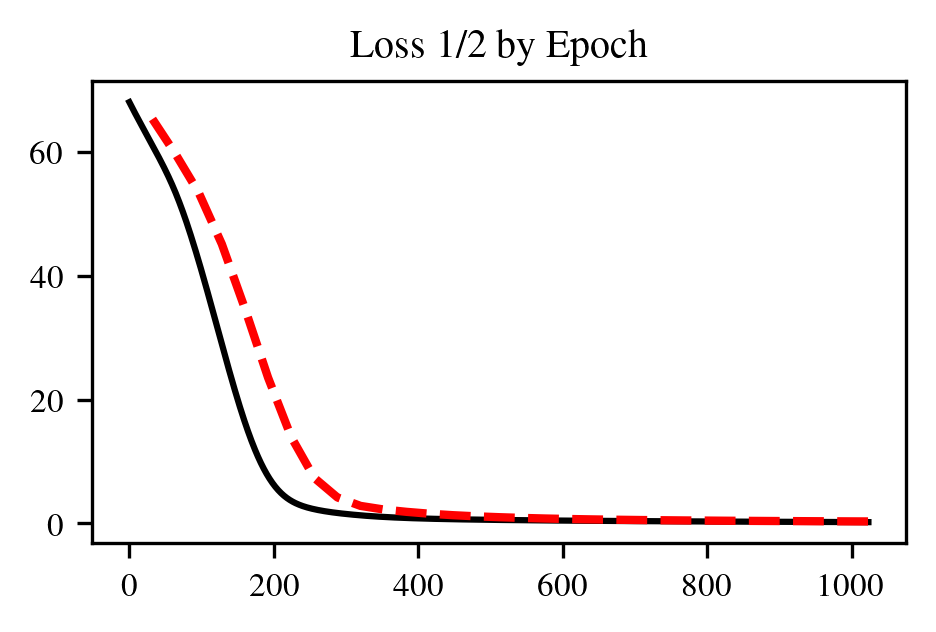

In [462]:
rows = 1024
features = 4
k = np.random.randint(0,10,(features,1))
X = np.random.normal(0,1,(rows,features))
y = np.dot(X,k) + 0.1 + np.random.normal(0,0.01,(rows,1))

np.random.seed(42)
nn = NeuralNet(features, 1, [18, 12])
epochs = 1024
loss_1 = [nn.adjust_weights(X, y) for _ in range(epochs)] 

np.random.seed(42)
nn = NeuralNet(features, 1, [18, 12])
epochs = 32
loss_2 = nn.train_net(X, y, epochs=epochs)[0]

plt.figure(figsize=(3.5, 2))   
plt.plot(loss_1)
plt.title("Loss 1 - Batch Gradient Descent")
plt.show()

plt.figure(figsize=(3.5, 2))   
plt.plot(loss_2)
plt.title("Loss 2 - Mini-Batch Stochastic Gradient Descent")
plt.show()

plt.figure(figsize=(3.5, 2))   
plt.title("Loss 1/2 by Epoch")
plt.plot(loss_1)
losses_by_epoch_2 = np.mean(np.array_split(loss_2, indices_or_sections = len(loss_2) / batch_count), axis=1)
plt.plot(np.arange(0, epochs * batch_size + batch_size, batch_size)[1:], losses_by_epoch_2, alpha=1, color='red', lw=2, zorder=2, label='Epoch Loss')
plt.show()

# JBV Networks, initial, R^2 of 0.4


Mean Absolute Error: 0.029770644243288093

Mean Squared Error: 0.004073430983559707

R^2: 0.44317428041399465


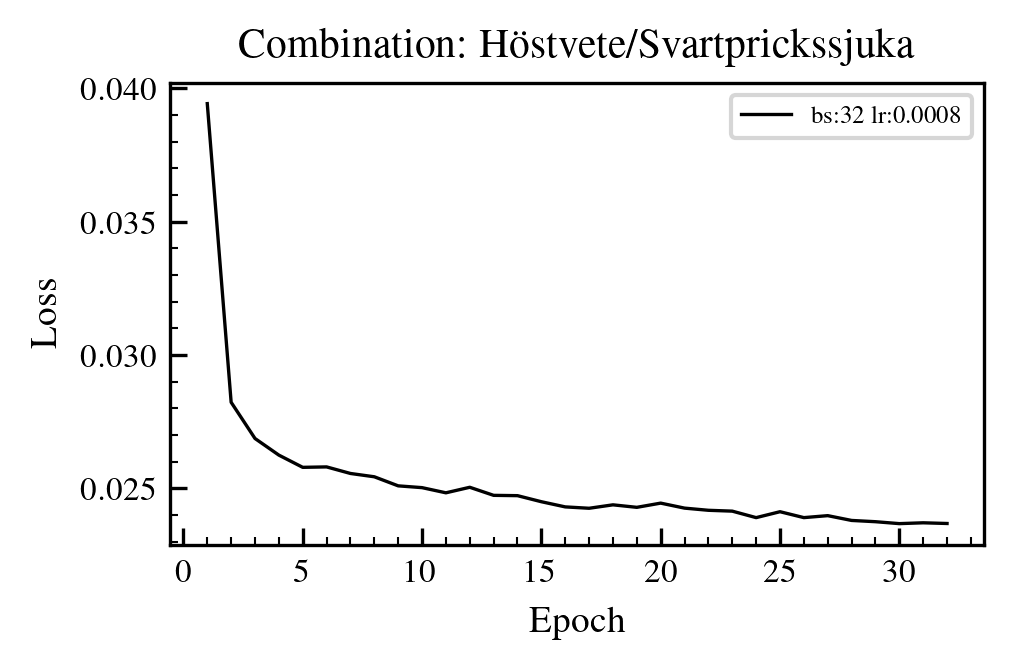

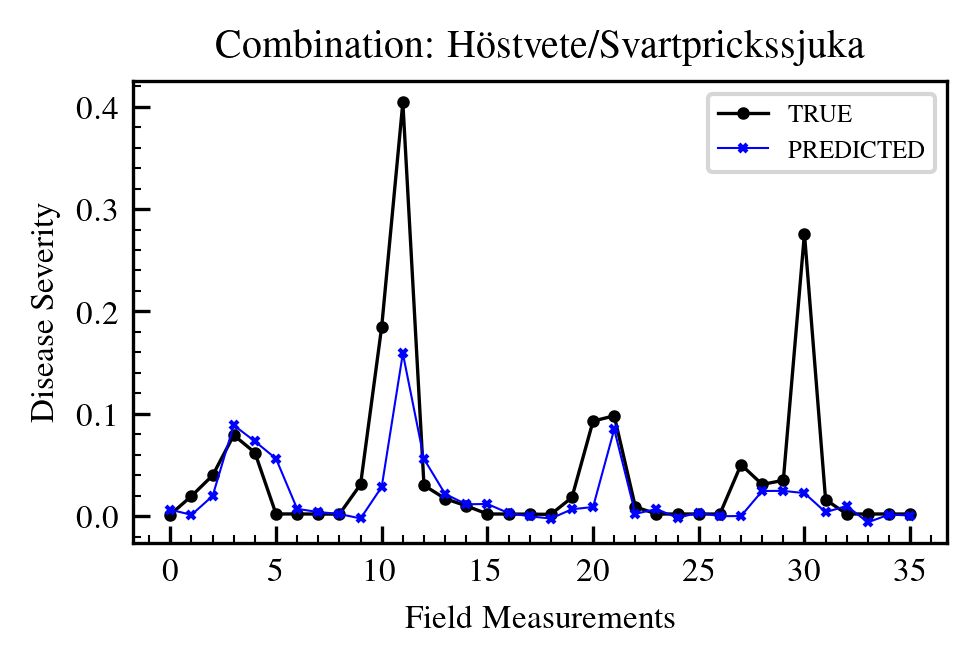

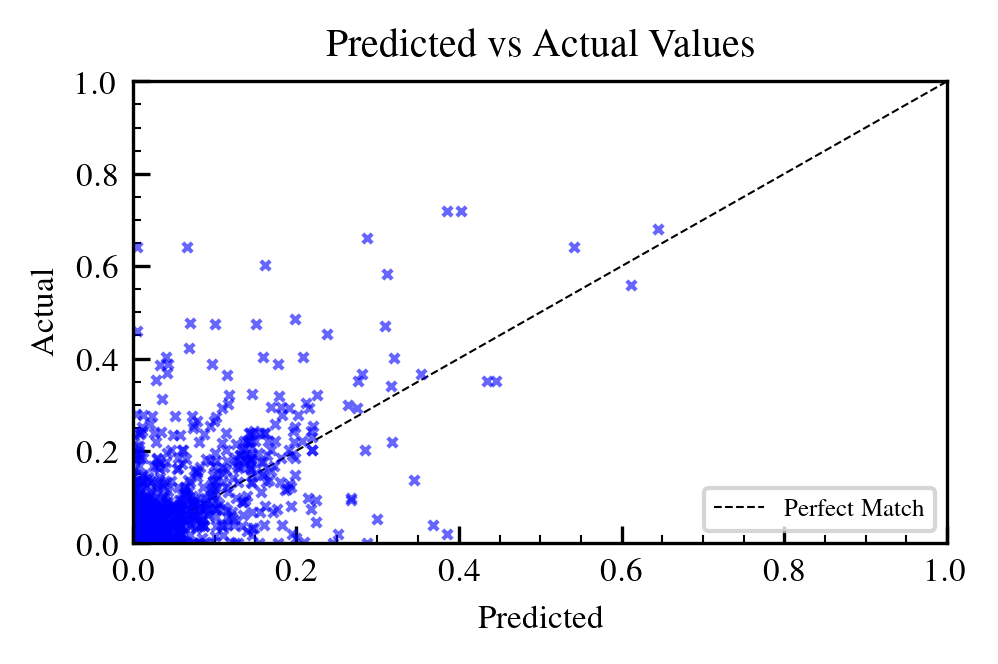

In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rows = 13016

batch_size = 32
epochs = 100
layer_sizes = 3 * [2*features]
patience = 8
learning_rate = 0.0008
X_train = np.array(pd.read_csv('nn_data/reg/inn_40/X_train_n.csv').drop(['Column0'], axis=1).head(rows - (rows % batch_size)))
y_train = np.array(pd.read_csv('nn_data/reg/inn_40/y_train_n.csv').drop(['Column0'], axis=1).head(rows - (rows % batch_size)))
X_test = np.array(pd.read_csv('nn_data/reg/inn_40/X_test_n.csv').drop(['Column0'], axis=1))
y_test = np.array(pd.read_csv('nn_data/reg/inn_40/y_test_n.csv').drop(['Column0'], axis=1))

features = pd.read_csv('nn_data/reg/inn_40/X_train_n.csv').drop(['Column0'], axis=1).shape[1]

nn = NeuralNet(input_dim=features, output_dim=1, neurons=layer_sizes, loss_function='quantile_loss',  activation_function='gelu', optimizer_type='adam', learning_rate=learning_rate)

activations = nn.forward(X_test)

losses_by_epoch = nn.train_net(X_train, y_train, epochs=epochs, batch_size=batch_size, use_validation_data=True, patience=patience)[1]
 
activations = nn.forward(X_test)
print('\nMean Absolute Error:', mean_absolute_error(y_true=y_test, y_pred=activations))
print('\nMean Squared Error:', mean_squared_error(y_true=y_test, y_pred=activations))
print('\nR^2:', r2_score(y_true=y_test, y_pred=activations))

plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300}) 
matplotlib.rcParams['font.size'] = 8  

actual_color = 'black'
pred_color = 'blue'
markersize = 2
lw_actual = 0.8
lw_pred = 0.5

plt.figure(figsize=(3.5, 2))
plt.plot(np.arange(1, len(losses_by_epoch) + 1), losses_by_epoch, color=actual_color, lw=lw_actual, 
         label=f'bs:{batch_size} lr:{learning_rate}')
plt.xlabel(f"Epoch", fontsize=9)
plt.ylabel(f'Loss', fontsize=9)
plt.title('Combination: Höstvete/Svartprickssjuka', fontsize=10)
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=True, fontsize=6, loc='upper right') 
plt.show()

plt.figure(figsize=(3.5, 2))   
from_p = 200
to_p = 236
plt.plot(range(len(y_test[from_p:to_p])),y_test[from_p:to_p], color=actual_color, lw=lw_actual, marker='o', markersize=markersize, label='TRUE')
plt.plot(range(len(activations[from_p:to_p])),activations[from_p:to_p], color=pred_color, lw=lw_pred, marker='x', markersize=markersize, linestyle='-', label='PREDICTED')
plt.xlabel('Field Measurements')
plt.ylabel('Disease Severity')
plt.title('Combination: Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=True, fontsize=6, loc='upper right') 
plt.show()

markersize = 5
marker_type = 'x' 
plt.figure(figsize=(3.5, 2))   
plt.title('Predicted vs Actual Values', fontweight='bold')
plt.scatter(activations, y_test, alpha=0.6, color='blue', marker=marker_type, s=markersize, zorder=2, lw=1)  
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5, zorder=1, label='Perfect Match')
plt.legend(frameon=True, fontsize=6, loc='lower right') 

plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.show()


# JBV ONLY - 0.80

In [537]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rows = 13200

batch_size = 32
epochs = 100
layer_sizes = 3 * [2*features]
patience = 8
learning_rate = 0.0008

folder = 'more_pests'
X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').drop(['Unnamed: 0'], axis=1).head(rows - (rows % batch_size))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').drop(['Unnamed: 0'], axis=1).head(rows - (rows % batch_size))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv').drop(['Unnamed: 0'], axis=1)
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv').drop(['Unnamed: 0'], axis=1)

X_train_isna = X_train.isna().any(axis=1)
X_test_isna = X_test.isna().any(axis=1)

X_train = np.array(X_train[~X_train_isna])
X_test = np.array(X_test[~X_test_isna])
y_train = np.array(y_train[~X_train_isna])
y_test = np.array(y_test[~X_test_isna])

features = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').drop(['Unnamed: 0'], axis=1).shape[1]

nn = NeuralNet(input_dim=features, output_dim=1, neurons=layer_sizes, loss_function='quantile_loss',  activation_function='gelu', optimizer_type='adam', learning_rate=learning_rate)

losses_by_epoch = nn.train_net(X_train, y_train, epochs=epochs, batch_size=batch_size, use_validation_data=True, patience=patience)[1]
 
activations = nn.forward(X_test)
print('\nMean Absolute Error:', mean_absolute_error(y_true=y_test, y_pred=activations))
print('\nMean Squared Error:', mean_squared_error(y_true=y_test, y_pred=activations))
print('\nR^2:', r2_score(y_true=y_test, y_pred=activations))


Mean Absolute Error: 0.0418348601120436

Mean Squared Error: 0.007046792381270679

R^2: 0.7973360217787895


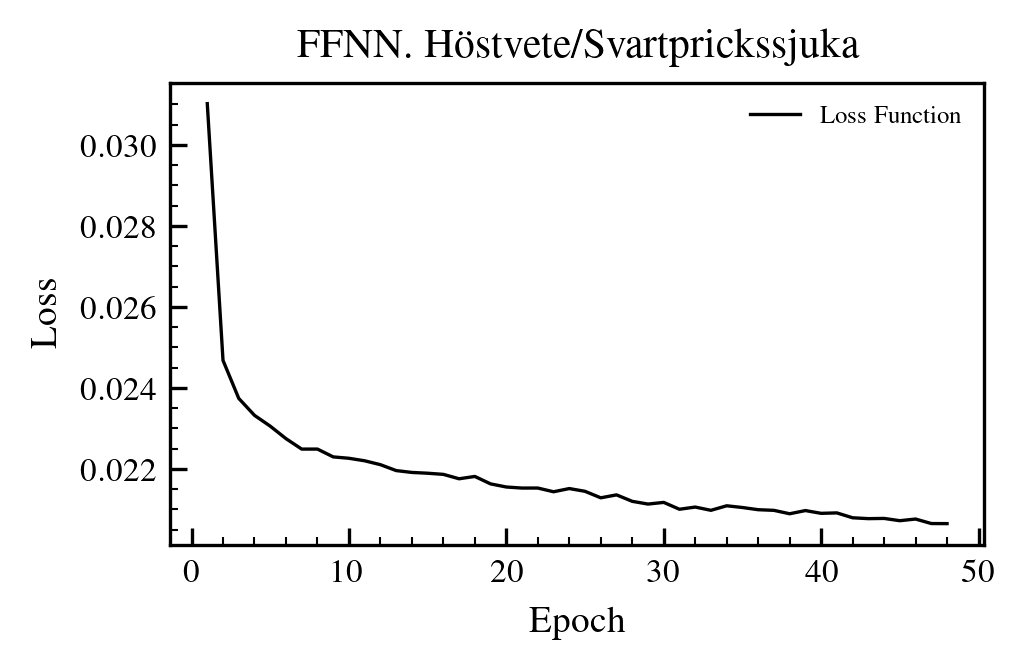

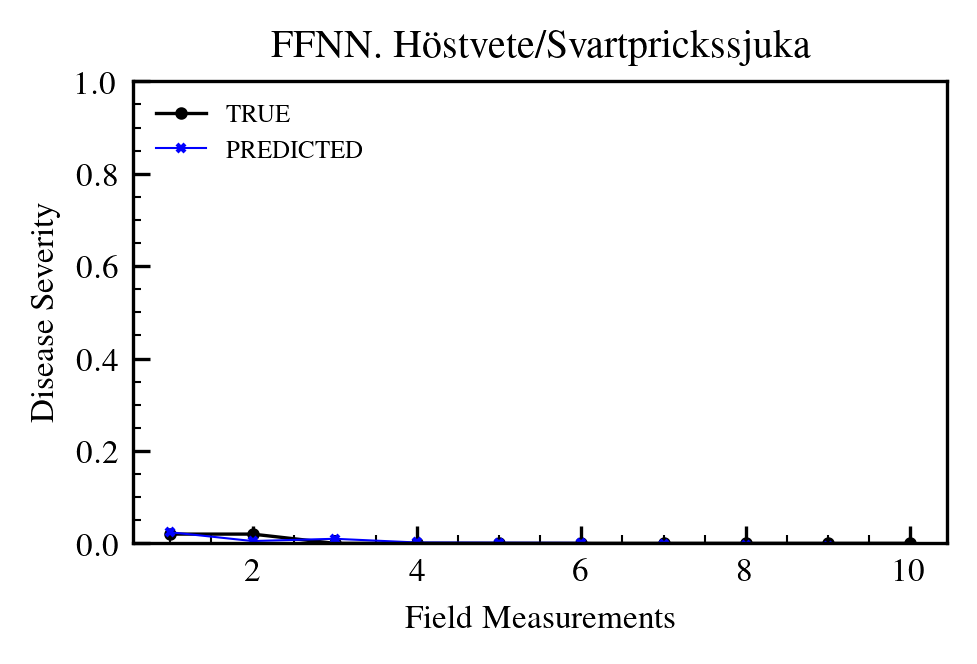

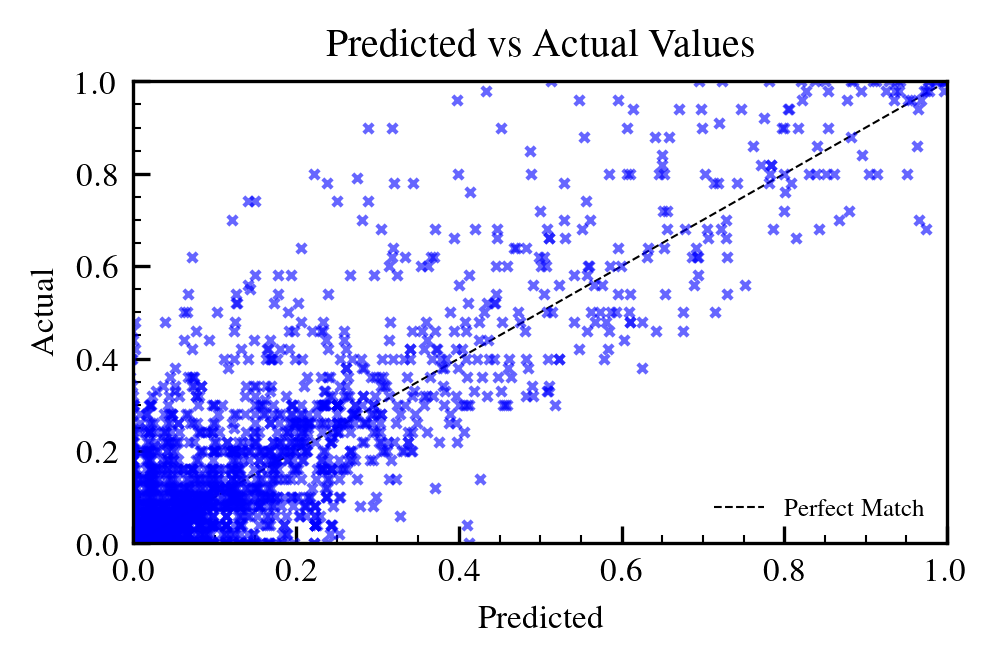

In [538]:
plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300}) 
matplotlib.rcParams['font.size'] = 8  

actual_color = 'black'
pred_color = 'blue'
markersize = 2
lw_actual = 0.8
lw_pred = 0.5

plt.figure(figsize=(3.5, 2))
plt.plot(np.arange(1, len(losses_by_epoch) + 1), losses_by_epoch, color=actual_color, lw=lw_actual, label='Loss Function')
plt.xlabel(f"Epoch", fontsize=9)
plt.ylabel(f'Loss', fontsize=9)
plt.title('FFNN. Höstvete/Svartprickssjuka', fontsize=10)
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper right') 
plt.show()

series_ids_test = X_test[:, 0]
unique_series = np.unique(series_ids_test)  
random_series = np.random.choice(unique_series)
mask = series_ids_test == random_series
y_selected = y_test[mask]
activations_selected = activations[mask]

plt.figure(figsize=(3.5, 2))
plt.plot(range(1, len(y_selected)+1), y_selected, color=actual_color, lw=lw_actual, 
         marker='o', markersize=markersize, label='TRUE')
plt.plot(range(1, len(activations_selected)+1), activations_selected, color=pred_color, 
         lw=lw_pred, marker='x', markersize=markersize, linestyle='-', label='PREDICTED')

plt.xlabel('Field Measurements')
plt.ylabel('Disease Severity')
plt.title(f'FFNN. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper left')
plt.ylim([0, 1])
plt.show()

markersize = 5
marker_type = 'x' 
plt.figure(figsize=(3.5, 2))   
plt.title('Predicted vs Actual Values', fontweight='bold')
plt.scatter(activations, y_test, alpha=0.6, color='blue', marker=marker_type, s=markersize, zorder=2, lw=1)  
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5, zorder=1, label='Perfect Match')
plt.legend(frameon=False, fontsize=6, loc='lower right') 

plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.show()

# JBV + WEATHER DATA (still 0.8)

In [465]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rows = 13016

batch_size = 32
epochs = 100
layer_sizes = 3 * [2*features]
patience = 8
learning_rate = 0.0008

folder = 'more_pests_weather'
X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').drop(['Unnamed: 0'], axis=1).head(rows - (rows % batch_size))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').drop(['Unnamed: 0'], axis=1).head(rows - (rows % batch_size))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv').drop(['Unnamed: 0'], axis=1)
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv').drop(['Unnamed: 0'], axis=1)

X_train_isna = X_train.isna().any(axis=1)
X_test_isna = X_test.isna().any(axis=1)

X_train = np.array(X_train[~X_train_isna])
X_test = np.array(X_test[~X_test_isna])
y_train = np.array(y_train[~X_train_isna])
y_test = np.array(y_test[~X_test_isna])

features = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').drop(['Unnamed: 0'], axis=1).shape[1]

nn = NeuralNet(input_dim=features, output_dim=1, neurons=layer_sizes, loss_function='quantile_loss',  activation_function='gelu', optimizer_type='adam', learning_rate=learning_rate)

losses_by_epoch = nn.train_net(X_train, y_train, epochs=epochs, batch_size=batch_size, use_validation_data=True, patience=patience)[1]
 
activations = nn.forward(X_test)
print('\nMean Absolute Error:', mean_absolute_error(y_true=y_test, y_pred=activations))
print('\nMean Squared Error:', mean_absolute_error(y_true=y_test, y_pred=activations))
print('\nR^2:', r2_score(y_true=y_test, y_pred=activations))


Mean Absolute Error: 0.05269890721754708

Mean Squared Error: 0.05269890721754708

R^2: 0.7882551288221471


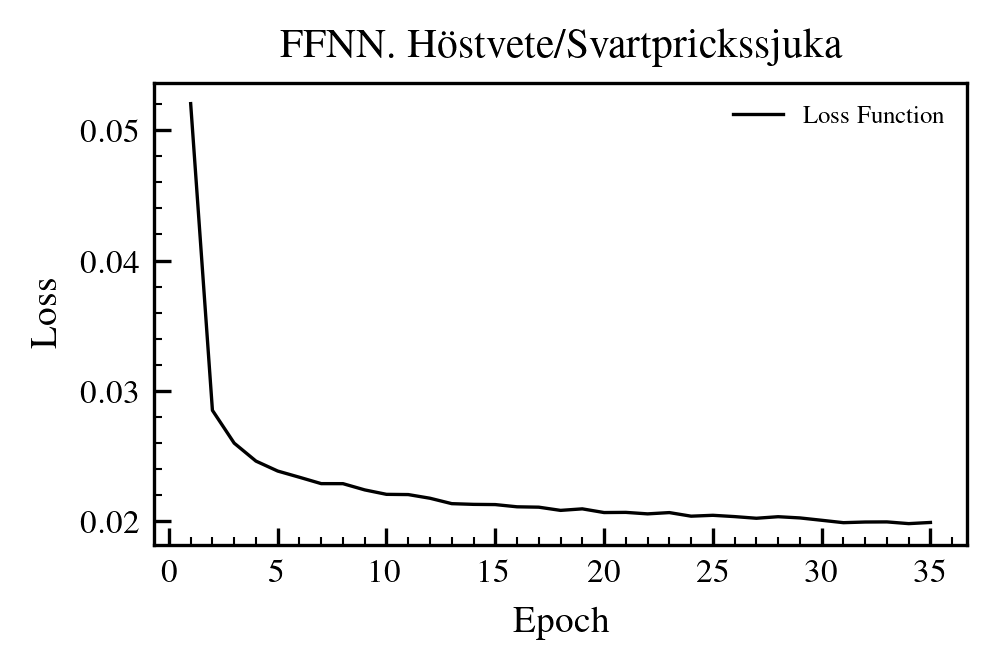

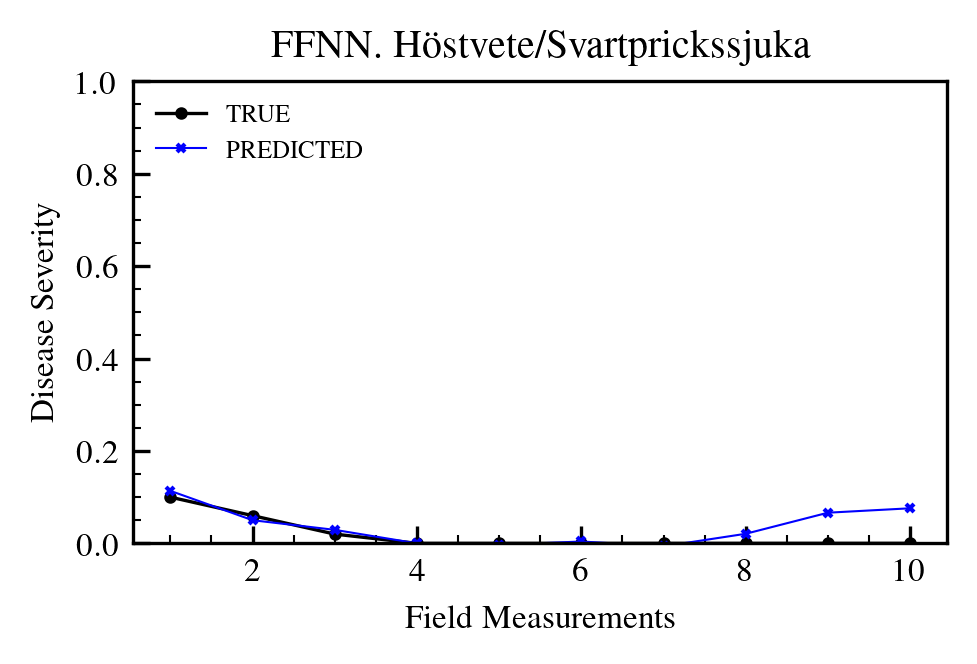

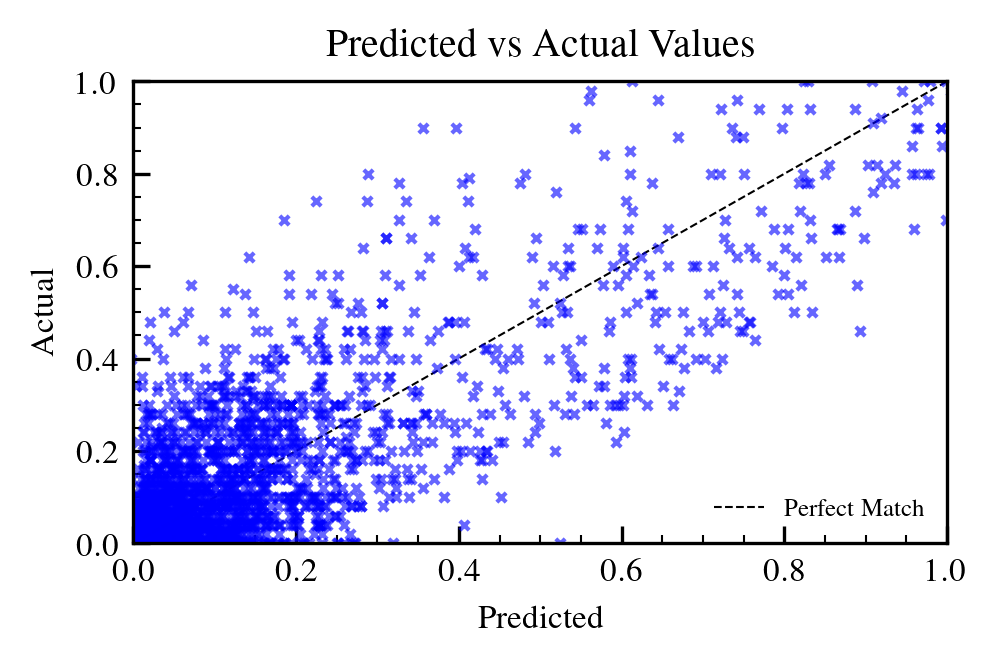

In [450]:
plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300}) 
matplotlib.rcParams['font.size'] = 8  

actual_color = 'black'
pred_color = 'blue'
markersize = 2
lw_actual = 0.8
lw_pred = 0.5

plt.figure(figsize=(3.5, 2))
plt.plot(np.arange(1, len(losses_by_epoch) + 1), losses_by_epoch, color=actual_color, lw=lw_actual, label='Loss Function')
plt.xlabel(f"Epoch", fontsize=9)
plt.ylabel(f'Loss', fontsize=9)
plt.title('FFNN. Höstvete/Svartprickssjuka', fontsize=10)
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper right') 
plt.show()

series_ids_test = X_test[:, 0]
unique_series = np.unique(series_ids_test)  
random_series = np.random.choice(unique_series)
mask = series_ids_test == random_series
y_selected = y_test[mask]
activations_selected = activations[mask]

plt.figure(figsize=(3.5, 2))
plt.plot(range(1, len(y_selected)+1), y_selected, color=actual_color, lw=lw_actual, 
         marker='o', markersize=markersize, label='TRUE')
plt.plot(range(1, len(activations_selected)+1), activations_selected, color=pred_color, 
         lw=lw_pred, marker='x', markersize=markersize, linestyle='-', label='PREDICTED')

plt.xlabel('Field Measurements')
plt.ylabel('Disease Severity')
plt.title(f'FFNN. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper left')
plt.ylim([0, 1])
plt.show()

markersize = 5
marker_type = 'x' 
plt.figure(figsize=(3.5, 2))   
plt.title('Predicted vs Actual Values', fontweight='bold')
plt.scatter(activations, y_test, alpha=0.6, color='blue', marker=marker_type, s=markersize, zorder=2, lw=1)  
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5, zorder=1, label='Perfect Match')
plt.legend(frameon=False, fontsize=6, loc='lower right') 

plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.show()

# JBV + Cumulative

In [533]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

rows = 16984

batch_size = 64
epochs = 100
layer_sizes = 4 * [int(1.5*features)]
patience = 8
learning_rate = 0.0004

folder = 'cumulative'
X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').drop([], axis=1).head(rows - (rows % batch_size))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').drop([], axis=1).head(rows - (rows % batch_size))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv').drop([], axis=1)
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv').drop([], axis=1)

X_train_isna = X_train.isna().any(axis=1)
X_test_isna = X_test.isna().any(axis=1)

X_train = np.array(X_train[~X_train_isna])
X_test = np.array(X_test[~X_test_isna])
y_train = np.array(y_train[~X_train_isna])
y_test = np.array(y_test[~X_test_isna])

features = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').drop([], axis=1).shape[1]

nn = NeuralNet(input_dim=features, output_dim=1, neurons=layer_sizes, loss_function='mse',  activation_function='gelu', optimizer_type='adam', learning_rate=learning_rate)

losses_by_epoch = nn.train_net(X_train, y_train, epochs=epochs, batch_size=batch_size, use_validation_data=True, patience=patience)[1]
 
activations = nn.forward(X_test)
print('\nMean Absolute Error:', mean_absolute_error(y_true=y_test, y_pred=activations))
print('\nMean Squared Error:', mean_squared_error(y_true=y_test, y_pred=activations))
print('\nR^2:', r2_score(y_true=y_test, y_pred=activations))


Mean Absolute Error: 0.06347616296637415

Mean Squared Error: 0.011454868739747045

R^2: 0.7871166077654544


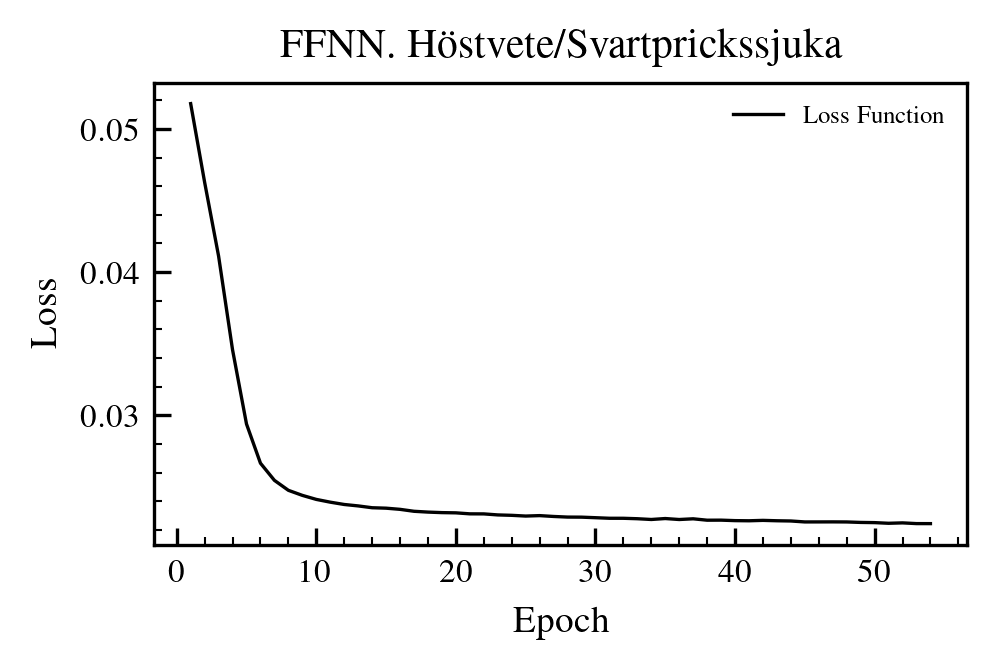

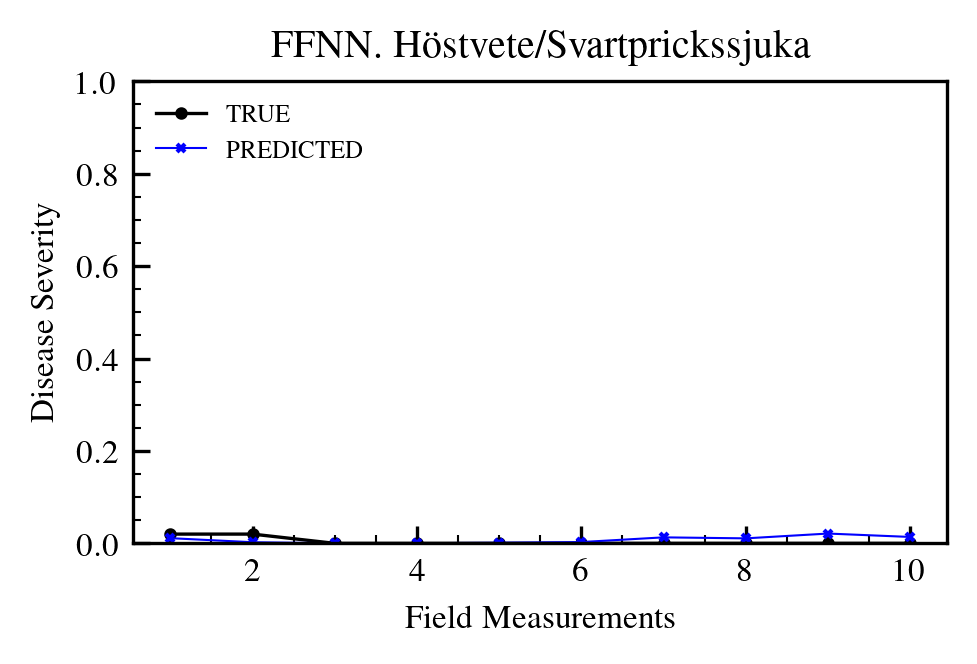

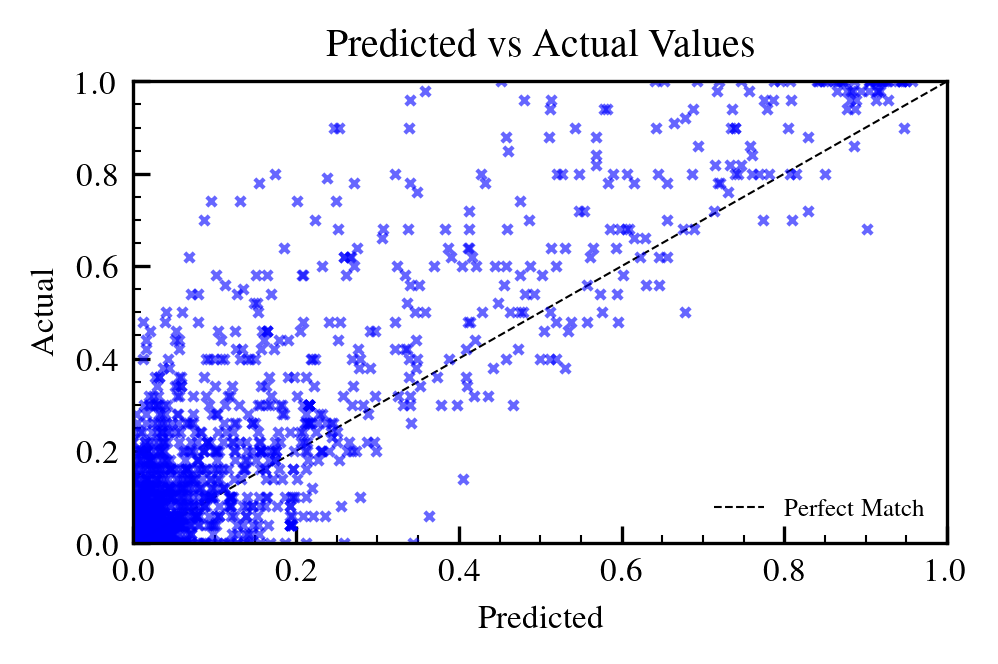

In [464]:
plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300}) 
matplotlib.rcParams['font.size'] = 8  

actual_color = 'black'
pred_color = 'blue'
markersize = 2
lw_actual = 0.8
lw_pred = 0.5

plt.figure(figsize=(3.5, 2))
plt.plot(np.arange(1, len(losses_by_epoch) + 1), losses_by_epoch, color=actual_color, lw=lw_actual, label='Loss Function')
plt.xlabel(f"Epoch", fontsize=9)
plt.ylabel(f'Loss', fontsize=9)
plt.title('FFNN. Höstvete/Svartprickssjuka', fontsize=10)
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper right') 
plt.show()

series_ids_test = X_test[:, 0]
unique_series = np.unique(series_ids_test)  
random_series = np.random.choice(unique_series)
mask = series_ids_test == random_series
y_selected = y_test[mask]
activations_selected = activations[mask]

plt.figure(figsize=(3.5, 2))
plt.plot(range(1, len(y_selected)+1), y_selected, color=actual_color, lw=lw_actual, 
         marker='o', markersize=markersize, label='TRUE')
plt.plot(range(1, len(activations_selected)+1), activations_selected, color=pred_color, 
         lw=lw_pred, marker='x', markersize=markersize, linestyle='-', label='PREDICTED')

plt.xlabel('Field Measurements')
plt.ylabel('Disease Severity')
plt.title(f'FFNN. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper left')
plt.ylim([0, 1])
plt.show()

markersize = 5
marker_type = 'x' 
plt.figure(figsize=(3.5, 2))   
plt.title('Predicted vs Actual Values', fontweight='bold')
plt.scatter(activations, y_test, alpha=0.6, color='blue', marker=marker_type, s=markersize, zorder=2, lw=1)  
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5, zorder=1, label='Perfect Match')
plt.legend(frameon=False, fontsize=6, loc='lower right') 

plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.show()

# Error Bounds

Training model for quantile 0.4


C:\Users\Mahmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for quantile 0.5


C:\Users\Mahmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for quantile 0.9


C:\Users\Mahmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Mean Absolute Error: 0.055458685399490816

Mean Squared Error: 0.010932131751217428

R^2: 0.7968314308588453


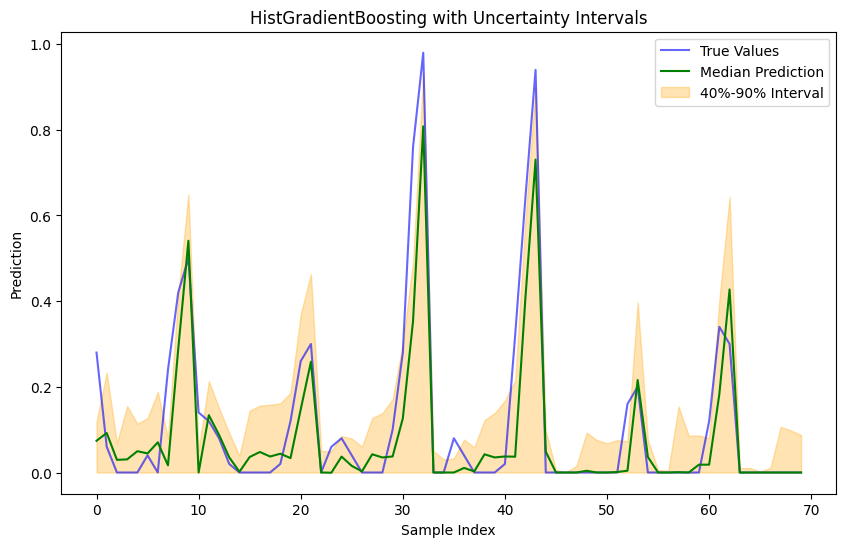

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

lb = 0.4
ub = 0.9
class HistGradBoostWithIntervals:
    def __init__(self, quantiles=[lb, 0.5, ub]):
        self.models = {q: HistGradientBoostingRegressor(loss='quantile', quantile=q) for q in quantiles}
        self.quantiles = quantiles

    def fit(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        for q, model in self.models.items():
            print(f"Training model for quantile {q}")
            model.fit(X_train, y_train)

    def predict(self, X):
        predictions = {q: model.predict(X) for q, model in self.models.items()}
        return predictions

    def plot_results(self, X, y_true):
        predictions = self.predict(X)
        median_pred = predictions[0.5]
        lower_bound = predictions[lb]
        upper_bound = predictions[ub]

        plt.figure(figsize=(10, 6))
        plt.plot(y_true, label='True Values', color='blue', alpha=0.6)
        plt.plot(median_pred, label='Median Prediction', color='green')
        plt.fill_between(range(len(y_true)), lower_bound, upper_bound, color='orange', alpha=0.3, label=f'{int(lb*100)}%-{int(100*ub)}% Interval')
        plt.xlabel('Sample Index')
        plt.ylabel('Prediction')
        plt.legend()
        plt.title('HistGradientBoosting with Uncertainty Intervals')
        plt.show()

# Load data
folder = 'cumulative'
rows = 16984

X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').head(rows)
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').head(rows)
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv')
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv')

# Clean data
X_train_isna = X_train.isna().any(axis=1)
X_test_isna = X_test.isna().any(axis=1)

X_train = np.array(X_train[~X_train_isna])
X_test = np.array(X_test[~X_test_isna])
y_train = np.array(y_train[~X_train_isna])
y_test = np.array(y_test[~X_test_isna])

# Train and predict
model = HistGradBoostWithIntervals()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate
median_pred = predictions[0.5]
print('\nMean Absolute Error:', mean_absolute_error(y_test, median_pred))
print('\nMean Squared Error:', mean_squared_error(y_test, median_pred))
print('\nR^2:', r2_score(y_test, median_pred))

# Plot results
model.plot_results(X_test[50:120], y_test[50:120])

# Ensamble NN

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import Huber

class EnsembleNN:
    def __init__(self, input_dim, num_models=5, learning_rate=0.000235, validation_split=0.2):
        self.input_dim = input_dim
        self.num_models = num_models
        self.learning_rate = learning_rate
        self.validation_split = validation_split
        self.models = []

    def build_base_model(self):
        model = keras.Sequential([
            layers.Dense(192, activation='leaky_relu', input_shape=(self.input_dim,)),
            layers.BatchNormalization(),
            layers.Dropout(0.07),
            layers.Dense(224, activation='leaky_relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.07),
            layers.Dense(1)
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss=Huber(),
                      metrics=['mae'])
        return model

    def fit(self, x_train, y_train, epochs=20, batch_size=32, patience=5):
        self.models = []
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=self.validation_split, random_state=42)
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        
        for i in range(self.num_models):
            print(f"Training model {i+1}/{self.num_models}")
            model = self.build_base_model()
            model.fit(x_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(x_val, y_val),
                      callbacks=[early_stopping],
                      verbose=1)
            self.models.append(model)

    def predict(self, x_test):
        if not self.models:
            raise ValueError("No models trained. Call fit() first.")
        predictions = np.column_stack([model.predict(x_test, verbose=0) for model in self.models])
        return np.clip(np.mean(predictions, axis=1), 0, 1)

# Load data
folder = 'cumulative'
rows = 16984
batch_size = 32

X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').head(rows - (rows % batch_size))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').head(rows - (rows % batch_size))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv')
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv')

# Clean data
X_train_isna = X_train.isna().any(axis=1)
X_test_isna = X_test.isna().any(axis=1)

X_train = np.array(X_train[~X_train_isna])
X_test = np.array(X_test[~X_test_isna])
y_train = np.array(y_train[~X_train_isna])
y_test = np.array(y_test[~X_test_isna])

# Train and predict
ensemble = EnsembleNN(input_dim=X_train.shape[1])
ensemble.fit(X_train, y_train)
predictions = ensemble.predict(X_test)

# Evaluate
print('\nMean Absolute Error:', mean_absolute_error(y_test, predictions))
print('\nMean Squared Error:', mean_squared_error(y_test, predictions))
print('\nR^2:', r2_score(y_test, predictions))


Training model 1/5
Epoch 1/20


C:\Users\Mahmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


424/424 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2020 - mae: 0.5027 - val_loss: 0.0099 - val_mae: 0.1080
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0927 - mae: 0.3348 - val_loss: 0.0126 - val_mae: 0.1190
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0661 - mae: 0.2818 - val_loss: 0.0104 - val_mae: 0.1086
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0506 - mae: 0.2451 - val_loss: 0.0080 - val_mae: 0.0965
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0404 - mae: 0.2166 - val_loss: 0.0053 - val_mae: 0.0741
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0305 - mae: 0.1886 - val_loss: 0.0052 - val_mae: 0.0718
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0252 - mae: 0.1710 - val_loss: 0.0050 - val_mae: 0.0713
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0197 - mae: 0.1501 - val_loss: 0.0041 - val_mae: 0.0609
Epoch 9/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0154 

# Cumulative With MODULE NN

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import Huber

rows = 16984
batch_size = 32
epochs = 20
learning_rate = 0.000235
patience = 5

def r_squared(y_true, y_pred):
    ss_total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))  
    ss_residual = tf.reduce_sum(tf.square(y_true - y_pred))  
    return 1 - (ss_residual / (ss_total + tf.keras.backend.epsilon()))  

def log_cosh_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true)))

folder='cumulative'
X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').drop([], axis=1).head(rows - (rows % batch_size))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').drop([], axis=1).head(rows - (rows % batch_size))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv').drop([], axis=1)
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv').drop([], axis=1)

X_train_isna = X_train.isna().any(axis=1)
X_test_isna = X_test.isna().any(axis=1)

X_train = np.array(X_train[~X_train_isna])
X_test = np.array(X_test[~X_test_isna])
y_train = np.array(y_train[~X_train_isna])
y_test = np.array(y_test[~X_test_isna])

features = X_train.shape[1]
layer_sizes = [192, 224]

model = keras.Sequential()
model.add(layers.Input(shape=(features,)))
for size in layer_sizes:
    model.add(layers.Dense(size, activation='leaky_relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.07))  
model.add(layers.Dense(1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=Huber(), metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                    callbacks=[early_stopping], verbose=1)

activations = model.predict(X_test).flatten()
activations = np.clip(activations, 0, 1)

print('\nMean Absolute Error:', mean_absolute_error(y_test, activations))
print('\nMean Absolute Error:', mean_squared_error(y_test, activations))
print('\nR^2:', r2_score(y_test, activations))

Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2171 - mae: 0.5250 - val_loss: 0.0854 - val_mae: 0.3868
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0954 - mae: 0.3395 - val_loss: 0.0304 - val_mae: 0.1934
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0709 - mae: 0.2909 - val_loss: 0.0486 - val_mae: 0.2545
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0542 - mae: 0.2518 - val_loss: 0.0120 - val_mae: 0.1192
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0406 - mae: 0.2164 - val_loss: 0.0077 - val_mae: 0.0925
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0332 - mae: 0.1965 - val_loss: 0.0094 - val_mae: 0.1049
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0263 - mae: 0.1729 - val_loss: 0.0071 - val_mae: 0.0878
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0212 - mae: 0.1558 - val_loss: 0.0053 - val_mae: 0.0756
Epoch 9/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - lo

In [545]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import keras_tuner as kt

# Load data
rows = 16984
folder = "cumulative" 
batch_sizes = [16, 32, 64, 128, 256]  # Expanded batch sizes for more comprehensive search

X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').drop([], axis=1).head(rows - (rows % max(batch_sizes)))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').drop([], axis=1).head(rows - (rows % max(batch_sizes)))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv').drop([], axis=1)
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv').drop([], axis=1)

# Handle NaN values
X_train = X_train.dropna()
X_test = X_test.dropna()
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

features = X_train.shape[1]

def log_cosh_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true)))

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(features,)))
    
    for i in range(hp.Int("num_layers", 2, 6)):  # Increased range for more depth exploration
        model.add(layers.Dense(hp.Int(f"units_{i}", min_value=features, max_value=features*6, step=features), activation='swish'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(hp.Float("dropout", 0.1, 0.6, step=0.1)))  # Wider range for dropout
    
    model.add(layers.Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice("learning_rate", [0.00005, 0.0001, 0.0005, 0.0008, 0.001, 0.002])),  # Expanded learning rates
                  loss=log_cosh_loss)
    
    return model

# Hyperparameter tuning
for batch_size in batch_sizes:
    print(f"Starting tuning for batch size {batch_size}...")
    tuner = kt.BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=50,
        executions_per_trial=3,
        directory='tuner_results',
        project_name=f'ffnn_tuning_bs_{batch_size}',
        overwrite=True 
    )
    
    tuner.search(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2, verbose=1)  # Increased epochs
    
    print(f"Tuning completed for batch size {batch_size}. Finding best model...")
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)
    
    print(f"Training best model for batch size {batch_size}...")
    history = best_model.fit(X_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2, verbose=1)  # Increased training epochs
    
    print(f"Evaluating model for batch size {batch_size}...")
    predictions = best_model.predict(X_test).flatten()
    predictions = np.clip(predictions, 0, 1)
    
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    
    print(f"Batch Size: {batch_size}")
    print("Best Hyperparameters:", best_hps.values)
    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("R^2 Score:", r2)
    print(f"Completed batch size {batch_size}\n")

Starting tuning for batch size 16...

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_layers
26                |26                |units_0
0.3               |0.3               |dropout
156               |156               |units_1
0.001             |0.001             |learning_rate



Exception ignored in: <function _xla_gc_callback at 0x000002AB98485E40>
Traceback (most recent call last):
  File "C:\Users\Mahmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\jax\_src\lib\__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x000002AB98485E40>
Traceback (most recent call last):
  File "C:\Users\Mahmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\jax\_src\lib\__init__.py", line 97, in _xla_gc_callback
    xla_client._xla.collect_garbage()
KeyboardInterrupt: 


Epoch 1/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.3173 - val_loss: 0.0048
Epoch 2/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0197 - val_loss: 0.0055
Epoch 3/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0096 - val_loss: 0.0047
Epoch 4/20
845/845 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0086 - val_loss: 0.0047
Epoch 5/20
 27/845 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0084

KeyboardInterrupt: 

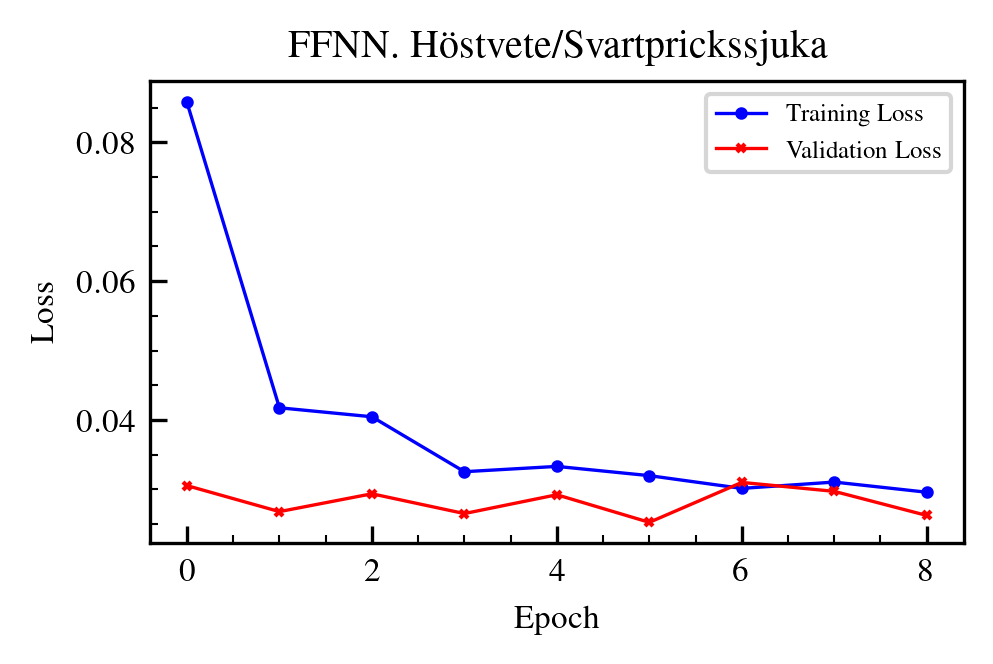

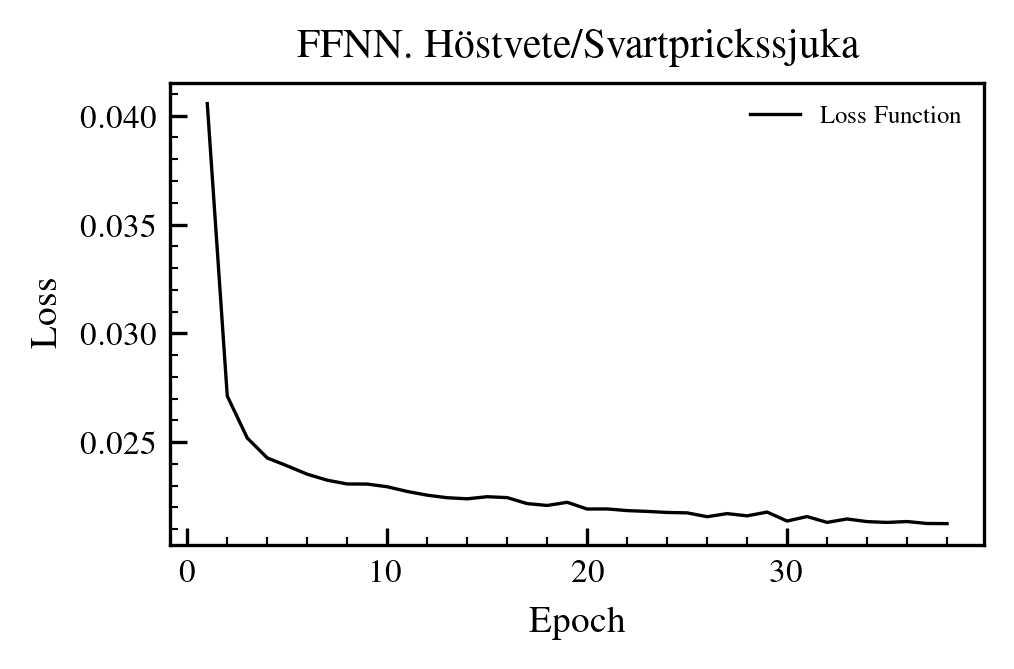

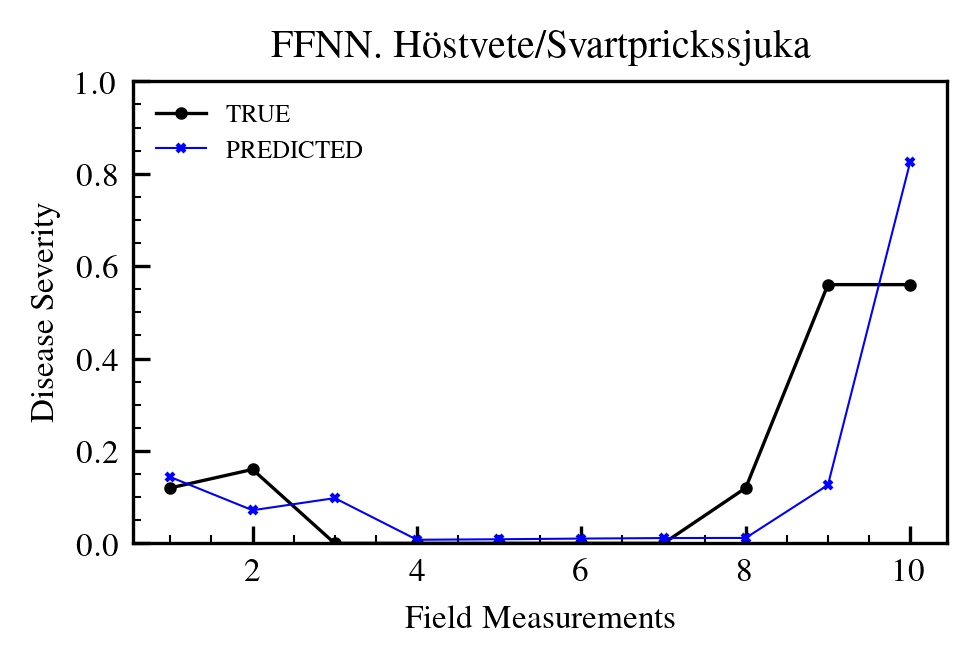

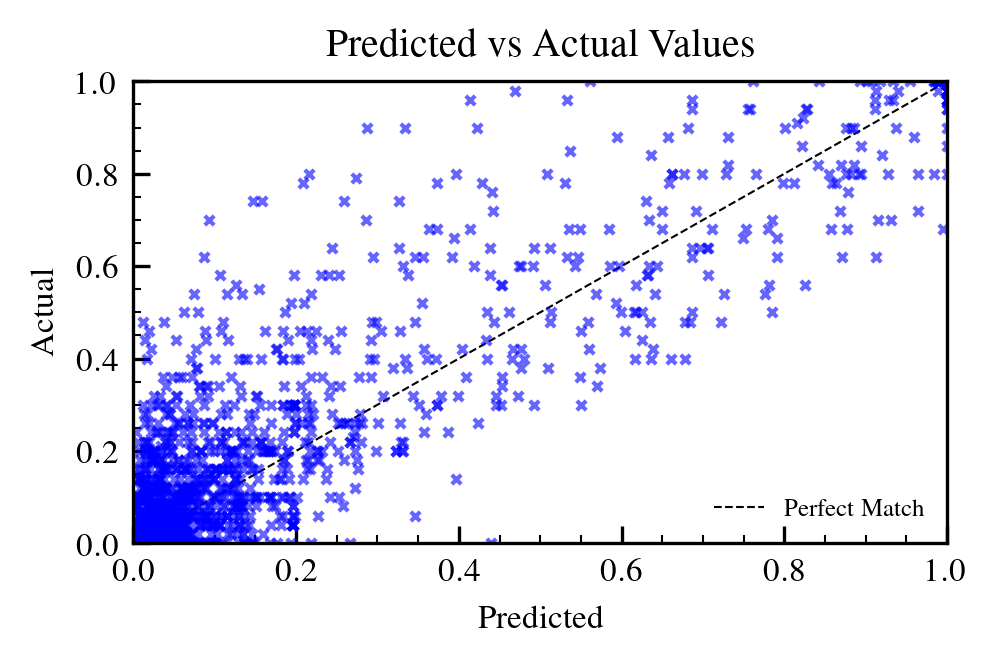

In [525]:
plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300}) 
matplotlib.rcParams['font.size'] = 8  

plt.figure(figsize=(3.5, 2))
plt.plot(history.history['loss'], label='Training Loss', color='blue', lw=0.8, marker='o', markersize=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', lw=0.8, marker='x', markersize=2, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FFNN. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=True, fontsize=6, loc='upper right')
plt.show()

actual_color = 'black'
pred_color = 'blue'
markersize = 2
lw_actual = 0.8
lw_pred = 0.5

plt.figure(figsize=(3.5, 2))
plt.plot(np.arange(1, len(losses_by_epoch) + 1), losses_by_epoch, color=actual_color, lw=lw_actual, label='Loss Function')
plt.xlabel(f"Epoch", fontsize=9)
plt.ylabel(f'Loss', fontsize=9)
plt.title('FFNN. Höstvete/Svartprickssjuka', fontsize=10)
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper right') 
plt.show()

series_ids_test = X_test[:, 0]
unique_series = np.unique(series_ids_test)  
random_series = np.random.choice(unique_series)
mask = series_ids_test == random_series
y_selected = y_test[mask]
activations_selected = activations[mask]

plt.figure(figsize=(3.5, 2))
plt.plot(range(1, len(y_selected)+1), y_selected, color=actual_color, lw=lw_actual, 
         marker='o', markersize=markersize, label='TRUE')
plt.plot(range(1, len(activations_selected)+1), activations_selected, color=pred_color, 
         lw=lw_pred, marker='x', markersize=markersize, linestyle='-', label='PREDICTED')

plt.xlabel('Field Measurements')
plt.ylabel('Disease Severity')
plt.title(f'FFNN. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper left')
plt.ylim([0, 1])
plt.show()

markersize = 5
marker_type = 'x' 
plt.figure(figsize=(3.5, 2))   
plt.title('Predicted vs Actual Values', fontweight='bold')
plt.scatter(activations, y_test, alpha=0.6, color='blue', marker=marker_type, s=markersize, zorder=2, lw=1)  
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5, zorder=1, label='Perfect Match')
plt.legend(frameon=False, fontsize=6, loc='lower right') 

plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.show()

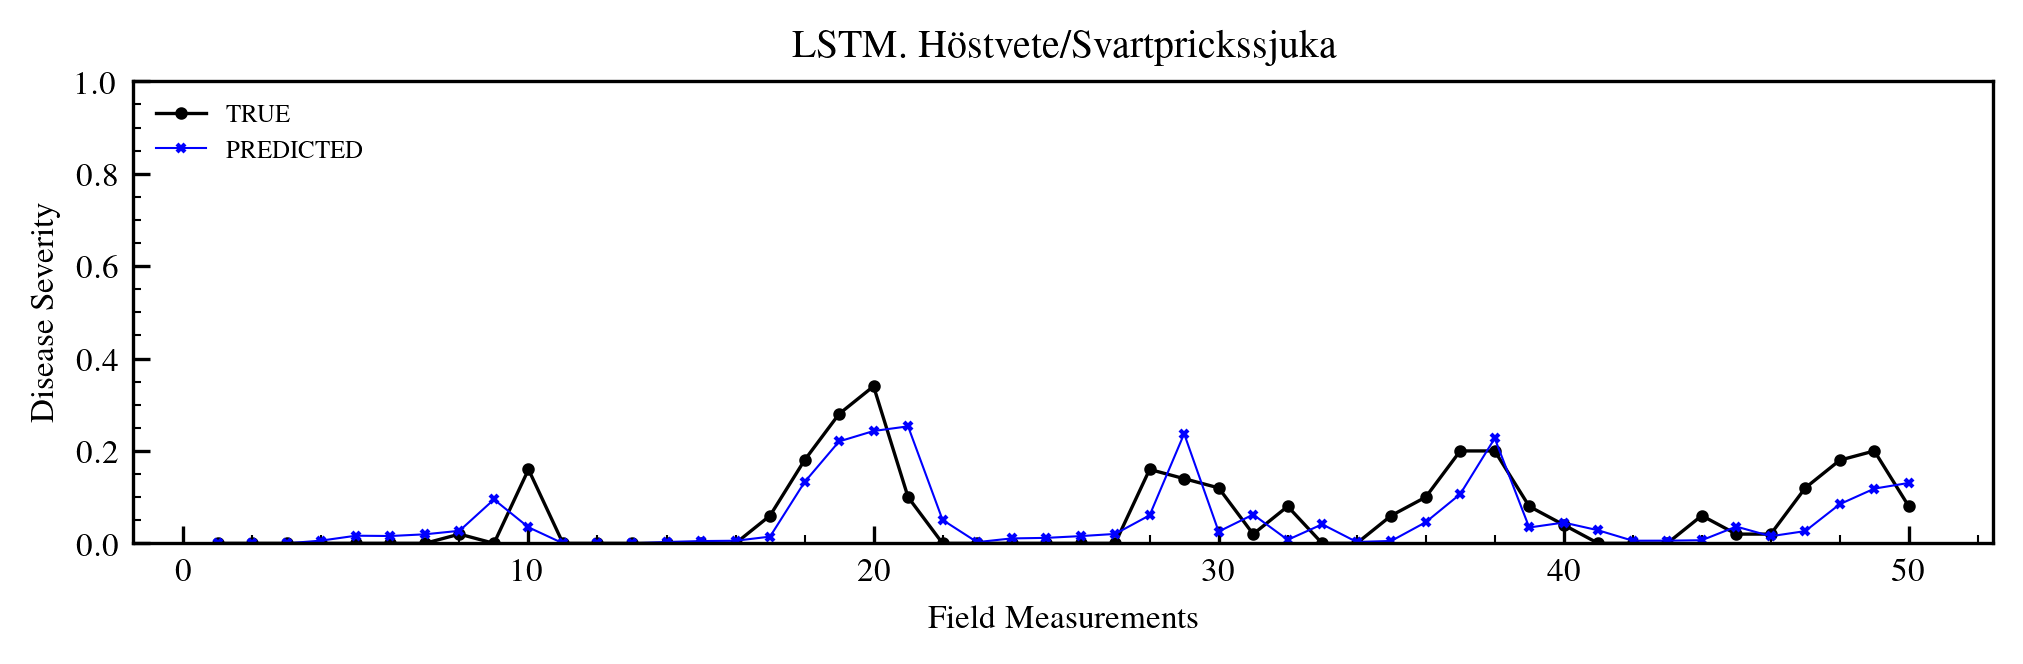

In [524]:
plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300}) 
matplotlib.rcParams['font.size'] = 8  

actual_color = 'black'
pred_color = 'blue'
markersize = 2
lw_actual = 0.8
lw_pred = 0.5

plt.figure(figsize=(8, 2))
plt.plot(range(1, len(y_test[:50]) + 1), y_test[:50], color=actual_color, lw=lw_actual, 
            marker='o', markersize=markersize, label='TRUE')
plt.plot(range(1, len(activations[:50]) + 1), activations[:50], color=pred_color, 
            lw=lw_pred, marker='x', markersize=markersize, linestyle='-', label='PREDICTED')

plt.xlabel('Field Measurements')
plt.ylabel('Disease Severity')
plt.title(f'LSTM. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper left')
plt.ylim([0, 1])
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score, mean_absolute_error

rows = 13016
batch_size = 32
epochs = 12
learning_rate = 0.0008
patience = 3
quantile = 0.55
folder = 'cumulative'
num_experiments = 10

def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))

X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').head(rows - (rows % batch_size))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').head(rows - (rows % batch_size))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv')
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv')

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

features = X_train.shape[1]
layer_sizes = 3 * [features * 2]

log_file = "experiment_log.txt"
with open(log_file, "w") as log:
    log.write(f"Experiment Settings:\n")
    log.write(f"Batch Size: {batch_size}\n")
    log.write(f"Epochs: {epochs}\n")
    log.write(f"Learning Rate: {learning_rate}\n")
    log.write(f"Patience: {patience}\n")
    log.write(f"Quantile: {quantile}\n")
    log.write(f"Dropout Rate: 0.4\n")
    log.write(f"Activation: Swish\n")
    log.write(f"Optimizer: Adam\n")
    log.write(f"Batch Normalization: Yes\n")
    log.write(f"Network Architecture: {layer_sizes} -> 1\n")
    log.write("\n---\n")

r2_scores = []

for experiment_idx in range(1, num_experiments + 1):
    print(f"Running Experiment {experiment_idx}...")

    with open(log_file, "a") as log:
        log.write(f"\n### Experiment {experiment_idx} ###\n")

    model = keras.Sequential()
    model.add(layers.Input(shape=(features,)))
    for size in layer_sizes:
        model.add(layers.Dense(size, activation='swish'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.4))  
    model.add(layers.Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=lambda y_true, y_pred: quantile_loss(quantile, y_true, y_pred))

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    class LogCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            with open(log_file, "a") as log:
                log.write(f"Epoch {epoch+1}/{epochs} - loss: {logs.get('loss'):.4f} - val_loss: {logs.get('val_loss'):.4f}\n")

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                        callbacks=[early_stopping, LogCallback()], verbose=1)

    activations = model.predict(X_test).flatten()
    activations = np.clip(activations, 0, 1)

    r2 = r2_score(y_test, activations)
    r2_scores.append(r2)

    with open(log_file, "a") as log:
        log.write(f"\nMean Absolute Error: {mean_absolute_error(y_test, activations):.6f}\n")
        log.write(f"R^2: {r2:.6f}\n")
        log.write(f"\n---\n")

avg_r2 = np.mean(r2_scores)
with open(log_file, "a") as log:
    log.write(f"\n### Final Results ###\n")
    log.write(f"Average R^2 over {num_experiments} experiments: {avg_r2:.6f}\n")

print(f"\nAverage R^2 over {num_experiments} experiments: {avg_r2:.6f}")


Running Experiment 1...
Epoch 1/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.4474 - val_loss: 0.0493
Epoch 2/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1471 - val_loss: 0.0342
Epoch 3/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0498 - val_loss: 0.0302
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Running Experiment 2...
Epoch 1/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.5180 - val_loss: 0.0646
Epoch 2/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2119 - val_loss: 0.0373
Epoch 3/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0637 - val_loss: 0.0345
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Running Experiment 3...
Epoch 1/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.4847 - val_loss: 0.0504
Epoch 2/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1676 - val_loss: 0.0355
Epoch 3/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0533 - val_loss: 0.0293
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Average R^2 over 3 experiments: 0.729210


# Transformer 0.8 (smooth in the bottom)

In [475]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score, mean_absolute_error

rows = 13016
batch_size = 64
epochs = 12
learning_rate = 0.008
patience = 3
quantile = 0.5
folder = 'cumulative'

def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))

X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').head(rows - (rows % batch_size))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').head(rows - (rows % batch_size))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv')
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv')

X_train_isna = X_train.isna().any(axis=1)
X_test_isna = X_test.isna().any(axis=1)

X_train = np.array(X_train[~X_train_isna])
X_test = np.array(X_test[~X_test_isna])
y_train = np.array(y_train[~X_train_isna])
y_test = np.array(y_test[~X_test_isna])

features = X_train.shape[1]
d_model = 64  

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.4):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="swish"),
            layers.Dense(embed_dim),
        ])
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs, inputs)  
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

class PositionEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        super(PositionEncoding, self).__init__()
        self.position_embedding = layers.Embedding(input_dim=max_len, output_dim=d_model)

    def call(self, x):
        positions = tf.range(start=0, limit=x.shape[1], delta=1)
        positions = self.position_embedding(positions)
        return x + positions

def build_transformer(features, d_model, num_heads=4, ff_dim=128, num_transformer_blocks=3):
    inputs = layers.Input(shape=(features,))

    x = layers.Dense(d_model, activation="swish")(inputs)
    x = layers.Reshape((1, d_model))(x)

    pos_encoding = PositionEncoding(features, d_model)(x)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim=d_model, num_heads=num_heads, ff_dim=ff_dim)(pos_encoding)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=x)
    return model

model = build_transformer(features, d_model)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss=lambda y_true, y_pred: quantile_loss(quantile, y_true, y_pred))

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                    callbacks=[early_stopping], verbose=1)

activations = model.predict(X_test).flatten()
activations = np.clip(activations, 0, 1)

print('\nMean Absolute Error:', mean_absolute_error(y_test, activations))
print('\nMean Squared Error:', mean_squared_error(y_test, activations))
print('\nR^2:', r2_score(y_test, activations))

Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.3862 - val_loss: 0.0510
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0591 - val_loss: 0.0498
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0581 - val_loss: 0.0397
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0401 - val_loss: 0.0279
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0310 - val_loss: 0.0387
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0290 - val_loss: 0.0364
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0291 - val_loss: 0.0305
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Mean Absolute Error: 0.061570090669399107

Mean Absolute Error: 0.011769616965825947

R^2: 0.7812671588027629


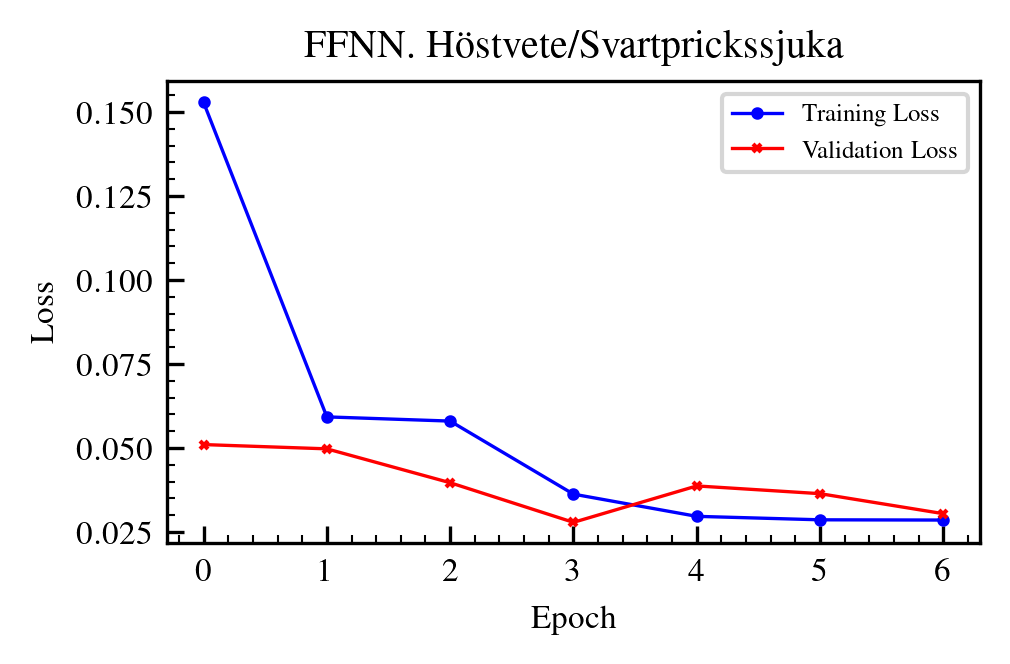

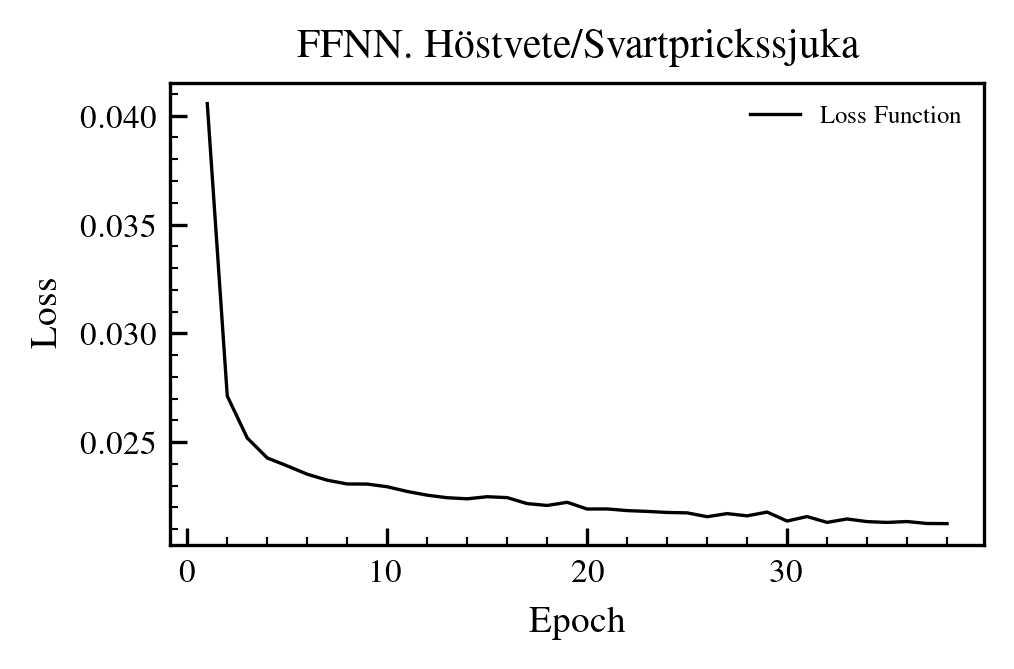

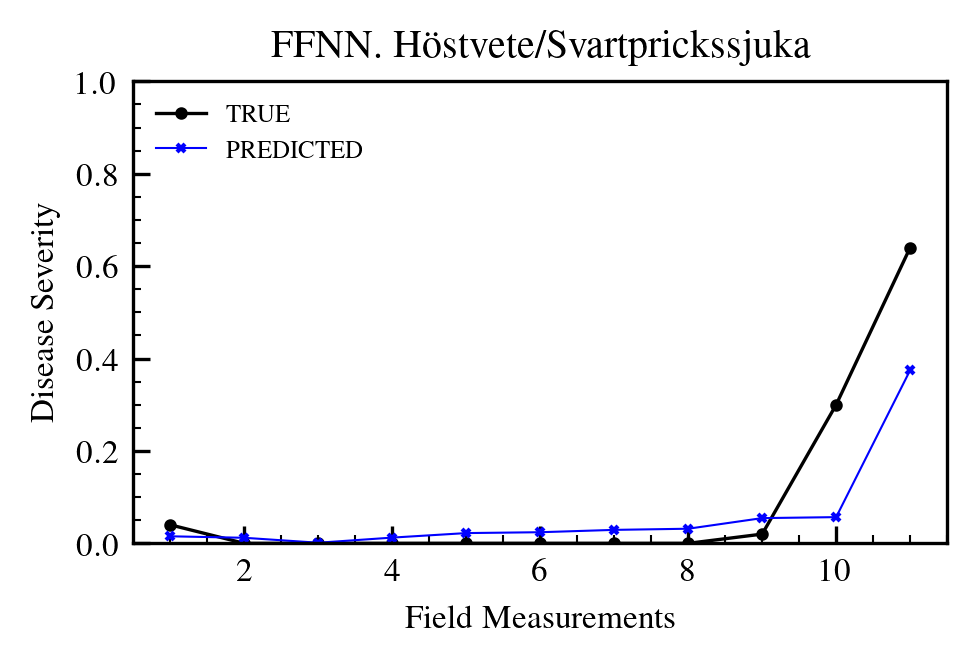

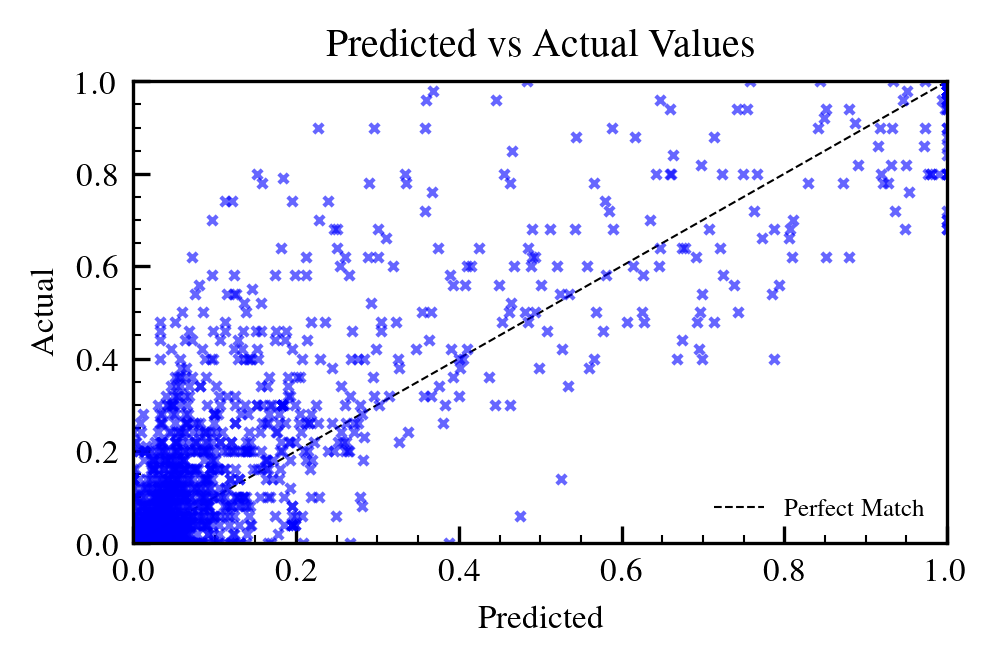

In [476]:
plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300}) 
matplotlib.rcParams['font.size'] = 8  

plt.figure(figsize=(3.5, 2))
plt.plot(history.history['loss'], label='Training Loss', color='blue', lw=0.8, marker='o', markersize=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', lw=0.8, marker='x', markersize=2, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FFNN. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=True, fontsize=6, loc='upper right')
plt.show()

actual_color = 'black'
pred_color = 'blue'
markersize = 2
lw_actual = 0.8
lw_pred = 0.5

plt.figure(figsize=(3.5, 2))
plt.plot(np.arange(1, len(losses_by_epoch) + 1), losses_by_epoch, color=actual_color, lw=lw_actual, label='Loss Function')
plt.xlabel(f"Epoch", fontsize=9)
plt.ylabel(f'Loss', fontsize=9)
plt.title('Transformer. Höstvete/Svartprickssjuka', fontsize=10)
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper right') 
plt.show()

series_ids_test = X_test[:, 0]
unique_series = np.unique(series_ids_test)  
random_series = np.random.choice(unique_series)
mask = series_ids_test == random_series
y_selected = y_test[mask]
activations_selected = activations[mask]

plt.figure(figsize=(3.5, 2))
plt.plot(range(1, len(y_selected)+1), y_selected, color=actual_color, lw=lw_actual, 
         marker='o', markersize=markersize, label='TRUE')
plt.plot(range(1, len(activations_selected)+1), activations_selected, color=pred_color, 
         lw=lw_pred, marker='x', markersize=markersize, linestyle='-', label='PREDICTED')

plt.xlabel('Field Measurements')
plt.ylabel('Disease Severity')
plt.title(f'Transformer. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper left')
plt.ylim([0, 1])
plt.show()

markersize = 5
marker_type = 'x' 
plt.figure(figsize=(3.5, 2))   
plt.title('Predicted vs Actual Values', fontweight='bold')
plt.scatter(activations, y_test, alpha=0.6, color='blue', marker=marker_type, s=markersize, zorder=2, lw=1)  
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5, zorder=1, label='Perfect Match')
plt.legend(frameon=False, fontsize=6, loc='lower right') 

plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.show()

# LSTM (0.80)

In [479]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score, mean_absolute_error

rows = 13016
batch_size = 64
epochs = 25
learning_rate = 0.005
patience = 3
quantile = 0.5
folder = 'cumulative'
timesteps = 1  

def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))

X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').head(rows - (rows % batch_size))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').head(rows - (rows % batch_size))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv')
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv')

X_train_isna = X_train.isna().any(axis=1)
X_test_isna = X_test.isna().any(axis=1)

X_train = np.array(X_train[~X_train_isna])
X_test = np.array(X_test[~X_test_isna])
y_train = np.array(y_train[~X_train_isna])
y_test = np.array(y_test[~X_test_isna])

features = X_train.shape[1]

X_train = X_train.reshape(-1, timesteps, features)
X_test = X_test.reshape(-1, timesteps, features)

def build_lstm(features, timesteps, units=features, dropout_rate=0.1):
    inputs = layers.Input(shape=(timesteps, features))

    x = layers.LSTM(2*units, return_sequences=True, dropout=dropout_rate)(inputs)
    x = layers.LayerNormalization()(x) 

    x = layers.LSTM(2*units, return_sequences=False, dropout=dropout_rate)(x)
    x = layers.LayerNormalization()(x) 

    x = layers.Dense(2*units, activation="swish")(x)
    x = layers.LayerNormalization()(x) 
    x = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=x)
    return model

model = build_lstm(features, timesteps)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
              loss=lambda y_true, y_pred: quantile_loss(quantile, y_true, y_pred))

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                    callbacks=[early_stopping], verbose=1)

activations = model.predict(X_test).flatten()
activations = np.clip(activations, 0, 1)

print('\nMean Absolute Error:', mean_absolute_error(y_test, activations))
print('\nMean Absolute Error:', mean_squared_error(y_test, activations))
print('\nR^2:', r2_score(y_test, activations))

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.1821 - val_loss: 0.0305
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0444 - val_loss: 0.0268
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0396 - val_loss: 0.0294
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0331 - val_loss: 0.0265
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0345 - val_loss: 0.0292
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0313 - val_loss: 0.0253
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0300 - val_loss: 0.0310
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0314 - val_loss: 0.0297
Epoch 9/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0313 - val_loss: 0.0262
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step

Mean Absolute Error: 0.05492368062016057

Mean Absolute Error: 0.009874464397199254

R^2: 0.8164876852686271


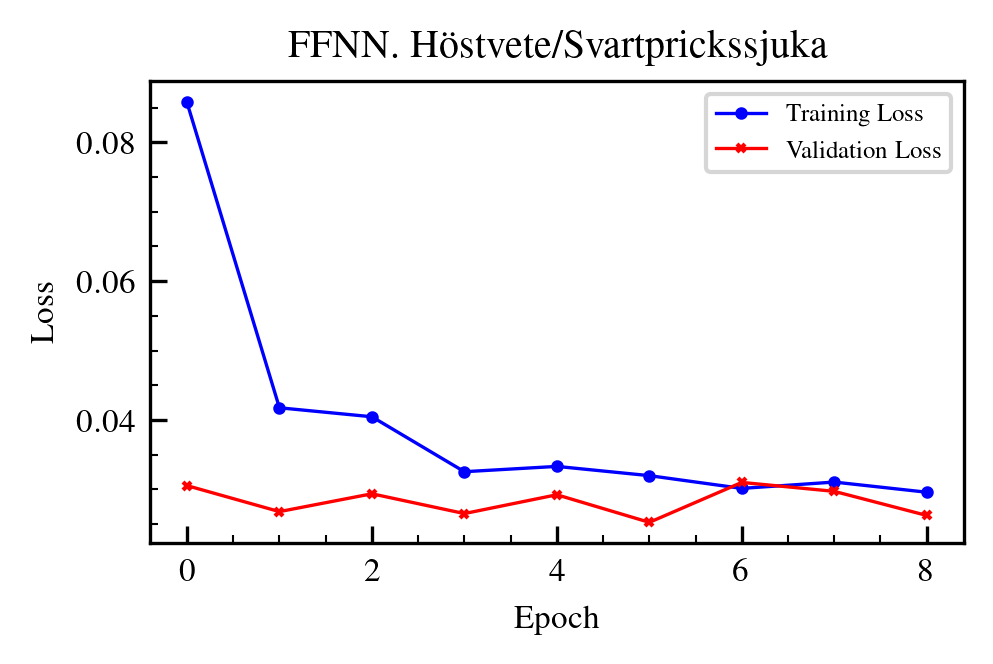

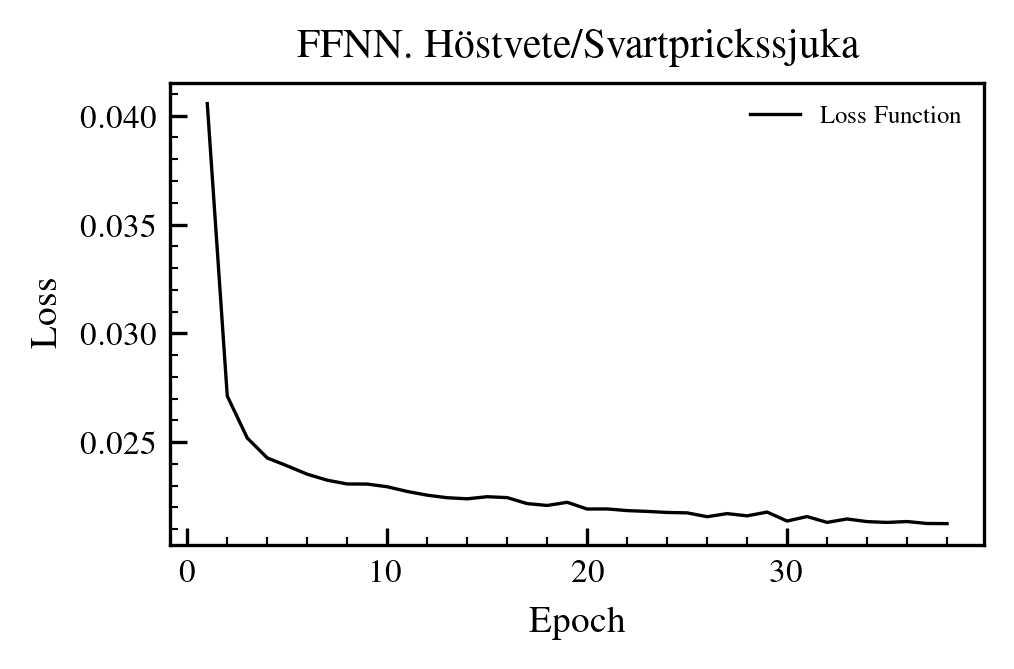

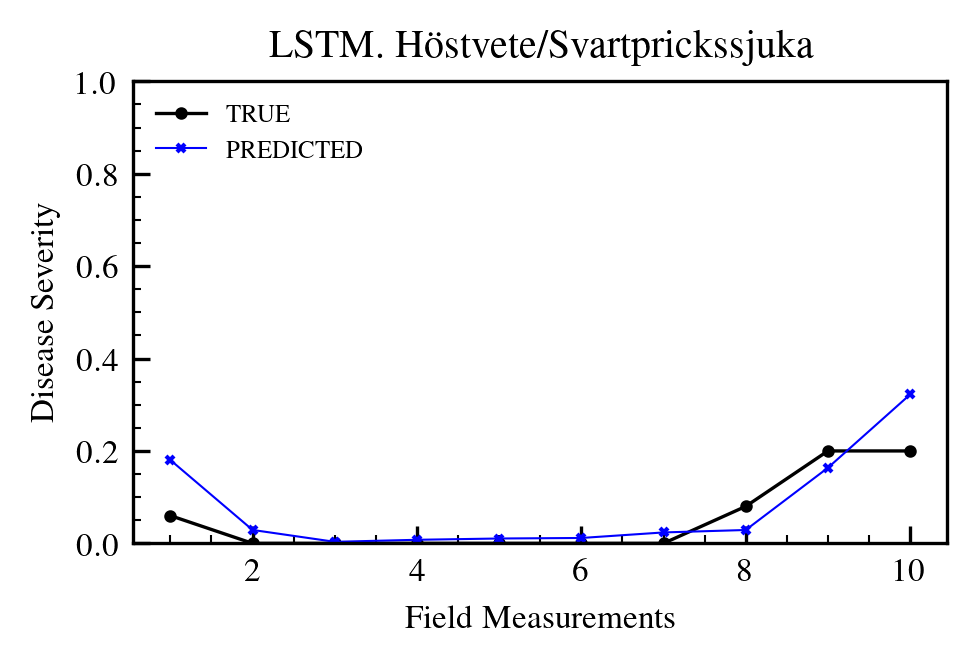

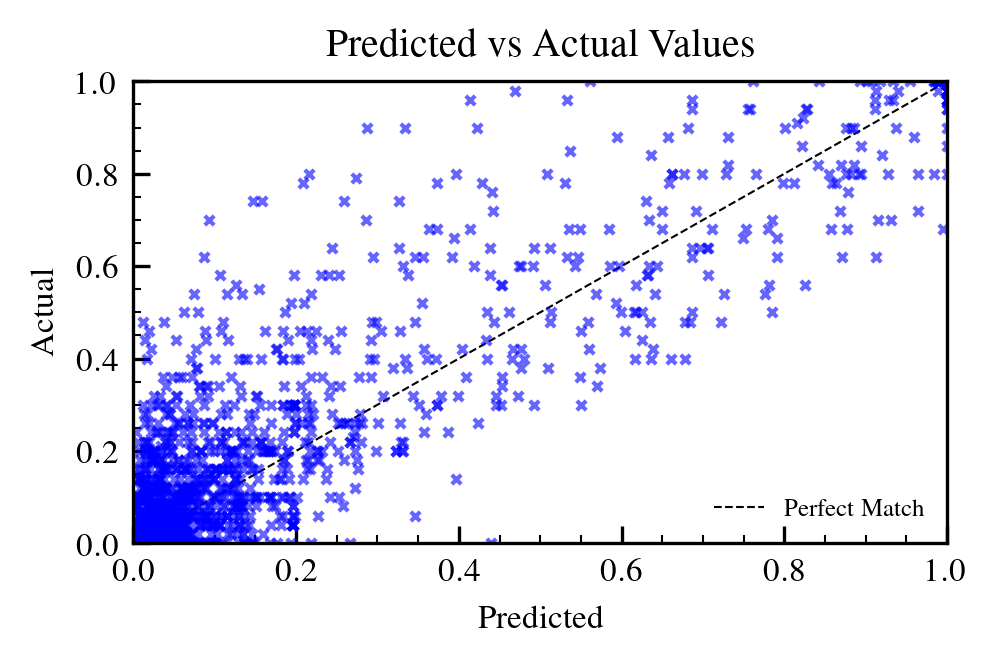

In [489]:
plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300}) 
matplotlib.rcParams['font.size'] = 8  

plt.figure(figsize=(3.5, 2))
plt.plot(history.history['loss'], label='Training Loss', color='blue', lw=0.8, marker='o', markersize=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', lw=0.8, marker='x', markersize=2, linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('FFNN. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=True, fontsize=6, loc='upper right')
plt.show()

actual_color = 'black'
pred_color = 'blue'
markersize = 2
lw_actual = 0.8
lw_pred = 0.5

plt.figure(figsize=(3.5, 2))
plt.plot(np.arange(1, len(losses_by_epoch) + 1), losses_by_epoch, color=actual_color, lw=lw_actual, label='Loss Function')
plt.xlabel(f"Epoch", fontsize=9)
plt.ylabel(f'Loss', fontsize=9)
plt.title('LSTM. Höstvete/Svartprickssjuka', fontsize=10)
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper right') 
plt.show()

series_ids_test = X_test[:, 0, 0]
unique_series = np.unique(series_ids_test)  
random_series = np.random.choice(unique_series)
mask = series_ids_test == random_series

y_selected = y_test[mask.flatten()]
activations_selected = activations[mask.flatten()]

plt.figure(figsize=(3.5, 2))
plt.plot(range(1, len(y_selected) + 1), y_selected, color=actual_color, lw=lw_actual, 
            marker='o', markersize=markersize, label='TRUE')
plt.plot(range(1, len(activations_selected) + 1), activations_selected, color=pred_color, 
            lw=lw_pred, marker='x', markersize=markersize, linestyle='-', label='PREDICTED')

plt.xlabel('Field Measurements')
plt.ylabel('Disease Severity')
plt.title(f'LSTM. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper left')
plt.ylim([0, 1])
plt.show()

markersize = 5
marker_type = 'x' 
plt.figure(figsize=(3.5, 2))   
plt.title('Predicted vs Actual Values', fontweight='bold')
plt.scatter(activations, y_test, alpha=0.6, color='blue', marker=marker_type, s=markersize, zorder=2, lw=1)  
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5, zorder=1, label='Perfect Match')
plt.legend(frameon=False, fontsize=6, loc='lower right') 

plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.show()

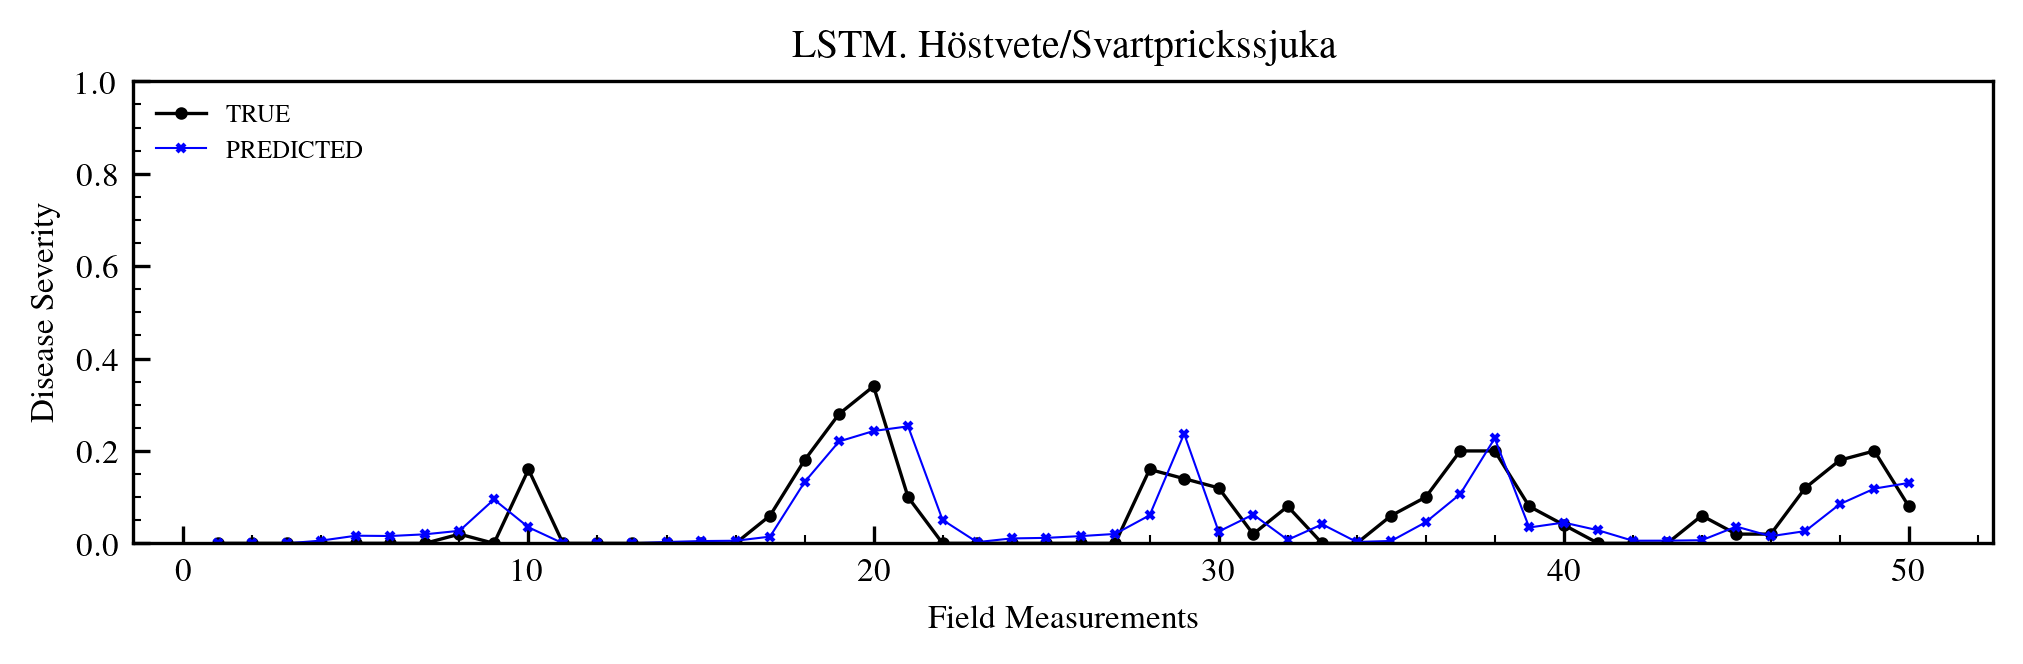

In [523]:
plt.style.use('ieee')
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif']
matplotlib.rcParams.update({'figure.dpi': 300}) 
matplotlib.rcParams['font.size'] = 8  

actual_color = 'black'
pred_color = 'blue'
markersize = 2
lw_actual = 0.8
lw_pred = 0.5

plt.figure(figsize=(8, 2))
plt.plot(range(1, len(y_test[:50]) + 1), y_test[:50], color=actual_color, lw=lw_actual, 
            marker='o', markersize=markersize, label='TRUE')
plt.plot(range(1, len(activations[:50]) + 1), activations[:50], color=pred_color, 
            lw=lw_pred, marker='x', markersize=markersize, linestyle='-', label='PREDICTED')

plt.xlabel('Field Measurements')
plt.ylabel('Disease Severity')
plt.title(f'LSTM. Höstvete/Svartprickssjuka')
plt.tick_params(axis='both', direction='in', length=4, width=0.8, which='major')
plt.minorticks_on()
plt.tick_params(axis='both', direction='in', length=2, width=0.5, which='minor')
plt.legend(frameon=False, fontsize=6, loc='upper left')
plt.ylim([0, 1])
plt.show()

# Correlation Analysis

In [506]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance

folder = 'cumulative'
X_train = pd.read_csv(f'nn_data/reg/{folder}/X_train.csv').head(rows - (rows % batch_size))
y_train = pd.read_csv(f'nn_data/reg/{folder}/y_train.csv').head(rows - (rows % batch_size))
X_test = pd.read_csv(f'nn_data/reg/{folder}/X_test.csv')
y_test = pd.read_csv(f'nn_data/reg/{folder}/y_test.csv')

feature_names = X_train.columns

X_train_isna = X_train.isna().any(axis=1)
X_test_isna = X_test.isna().any(axis=1)

X_train = np.array(X_train[~X_train_isna])
X_test = np.array(X_test[~X_test_isna])
y_train = np.array(y_train[~X_train_isna])
y_test = np.array(y_test[~X_test_isna])

X_combined = np.vstack((X_train, X_test))
y_combined = np.concatenate((y_train, y_test))

combined_df = pd.DataFrame(X_combined, columns=feature_names)
combined_df['Target'] = y_combined

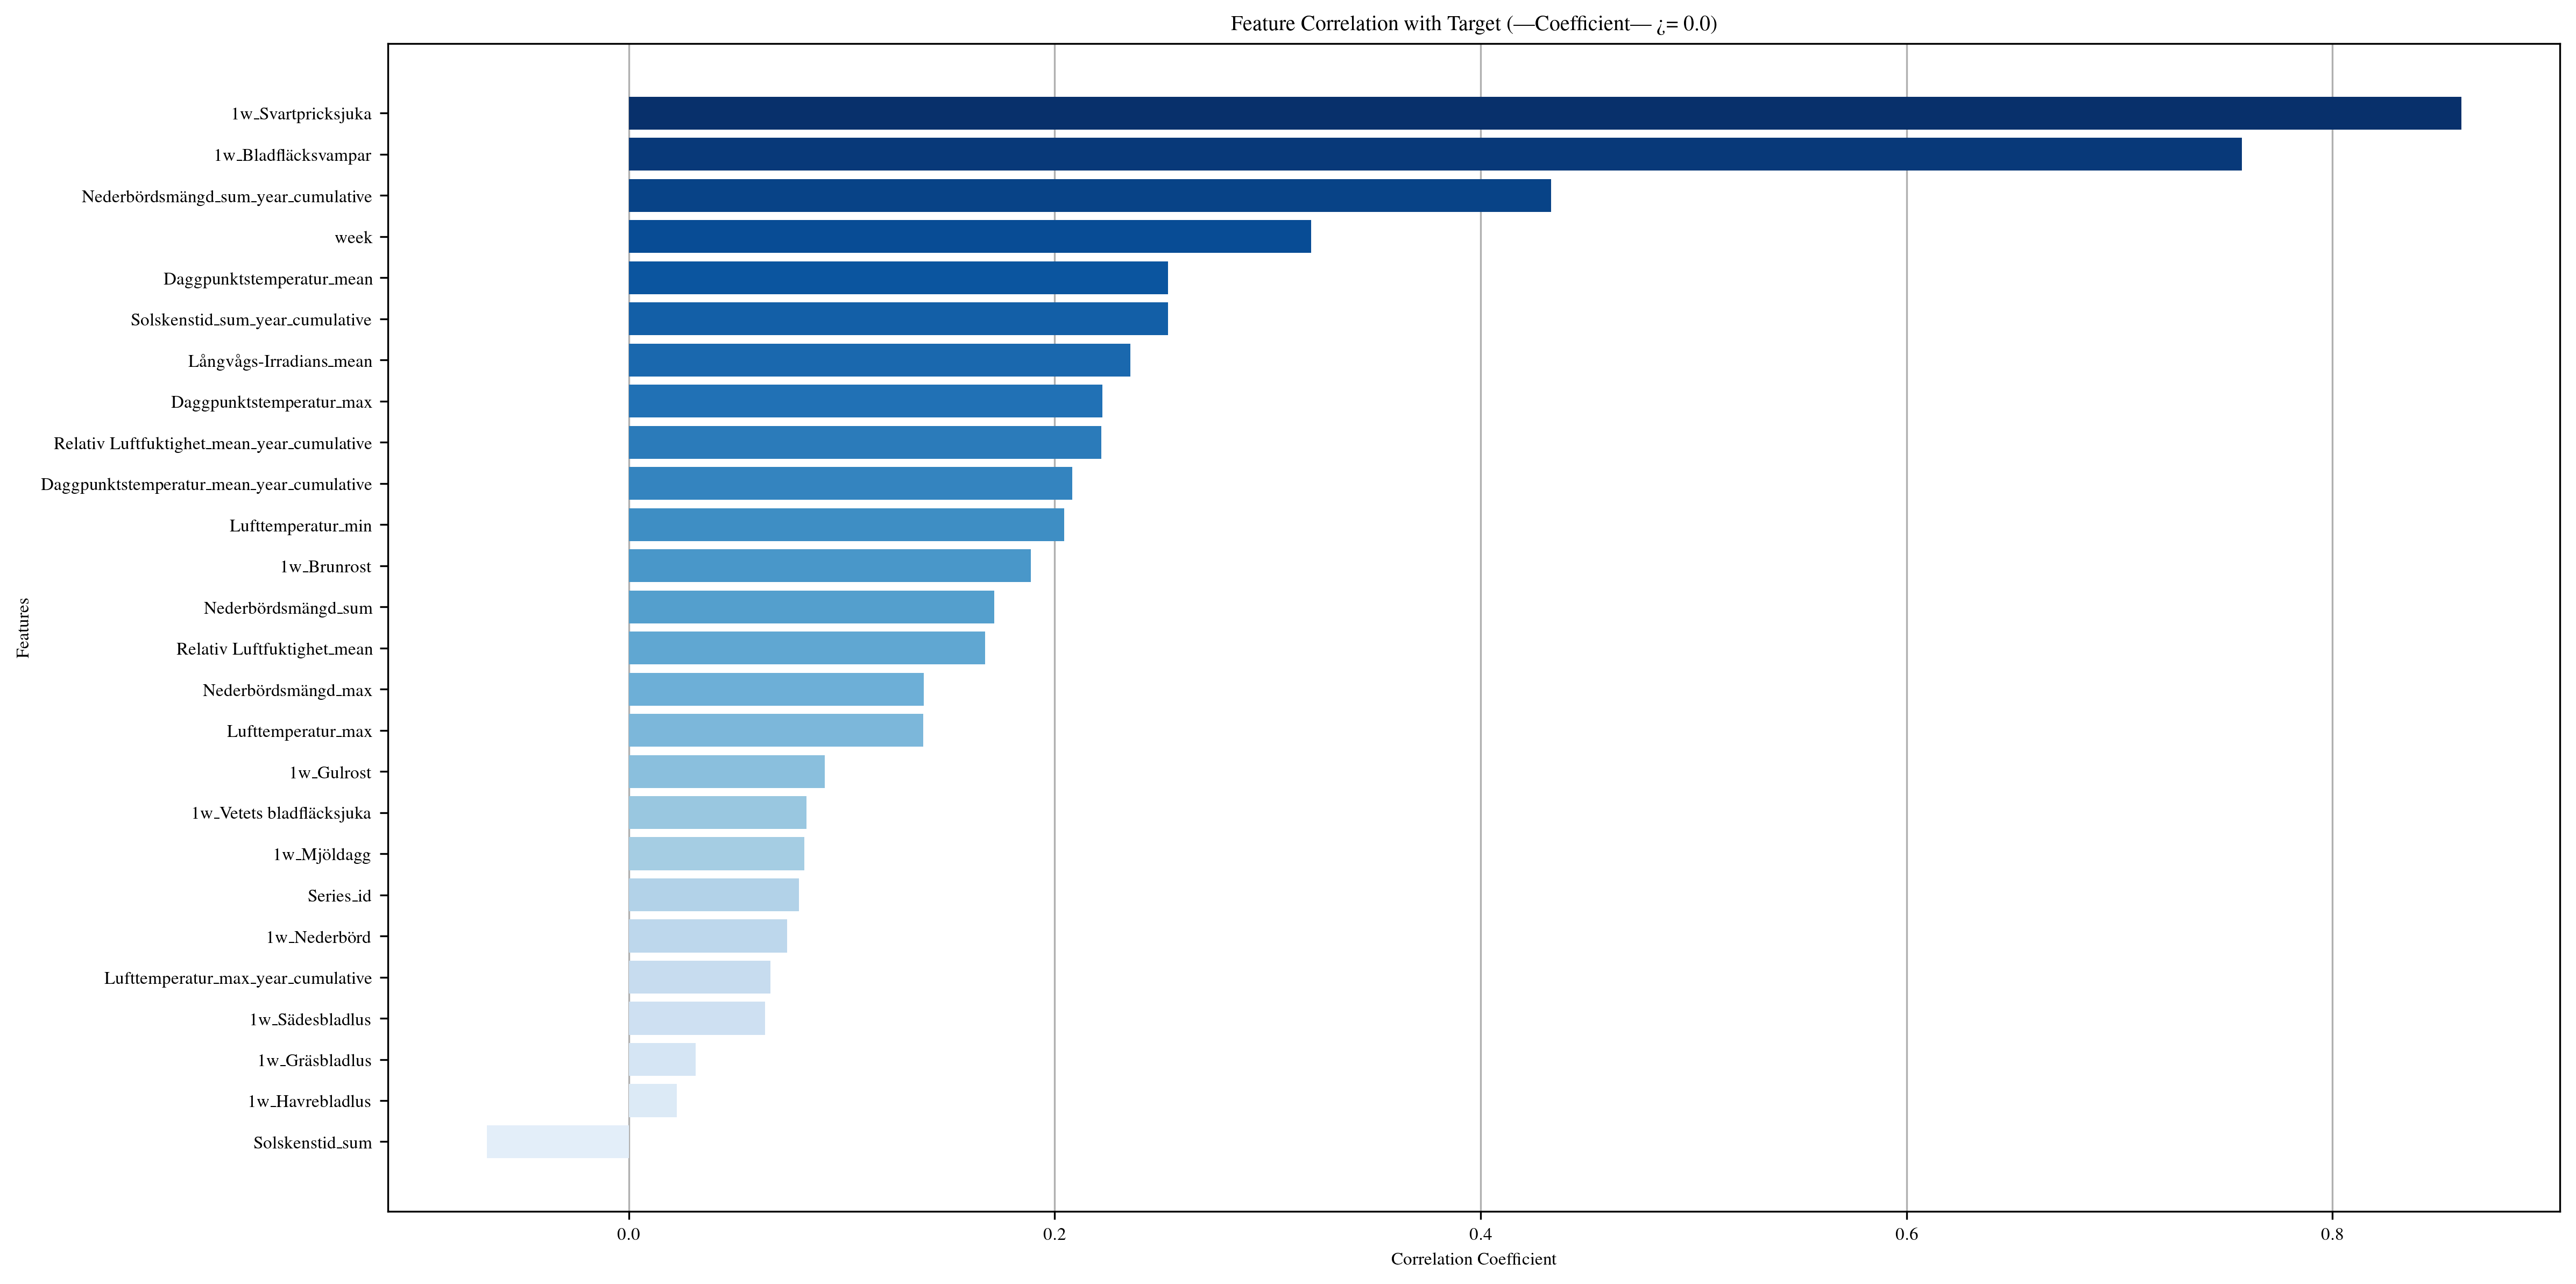

In [ ]:
# 1. Correlation Analysis
correlation_matrix = combined_df.corr()
target_correlation = correlation_matrix['Target'].drop('Target')

coef_eps = 0.00
filtered_target_correlation = target_correlation[abs(target_correlation) >= coef_eps]
filtered_target_correlation_df = filtered_target_correlation.sort_values(ascending=True)

colors = plt.cm.Blues(np.linspace(0.1, 1, len(filtered_target_correlation_df)))

plt.figure(figsize=(16, 8))
plt.barh(filtered_target_correlation_df.index, filtered_target_correlation_df.values, color=colors, zorder=2)
plt.title(f'Feature Correlation with Target (|Coefficient| >= {coef_eps})')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x', ls='-', zorder=1)
plt.tight_layout()  
plt.show()


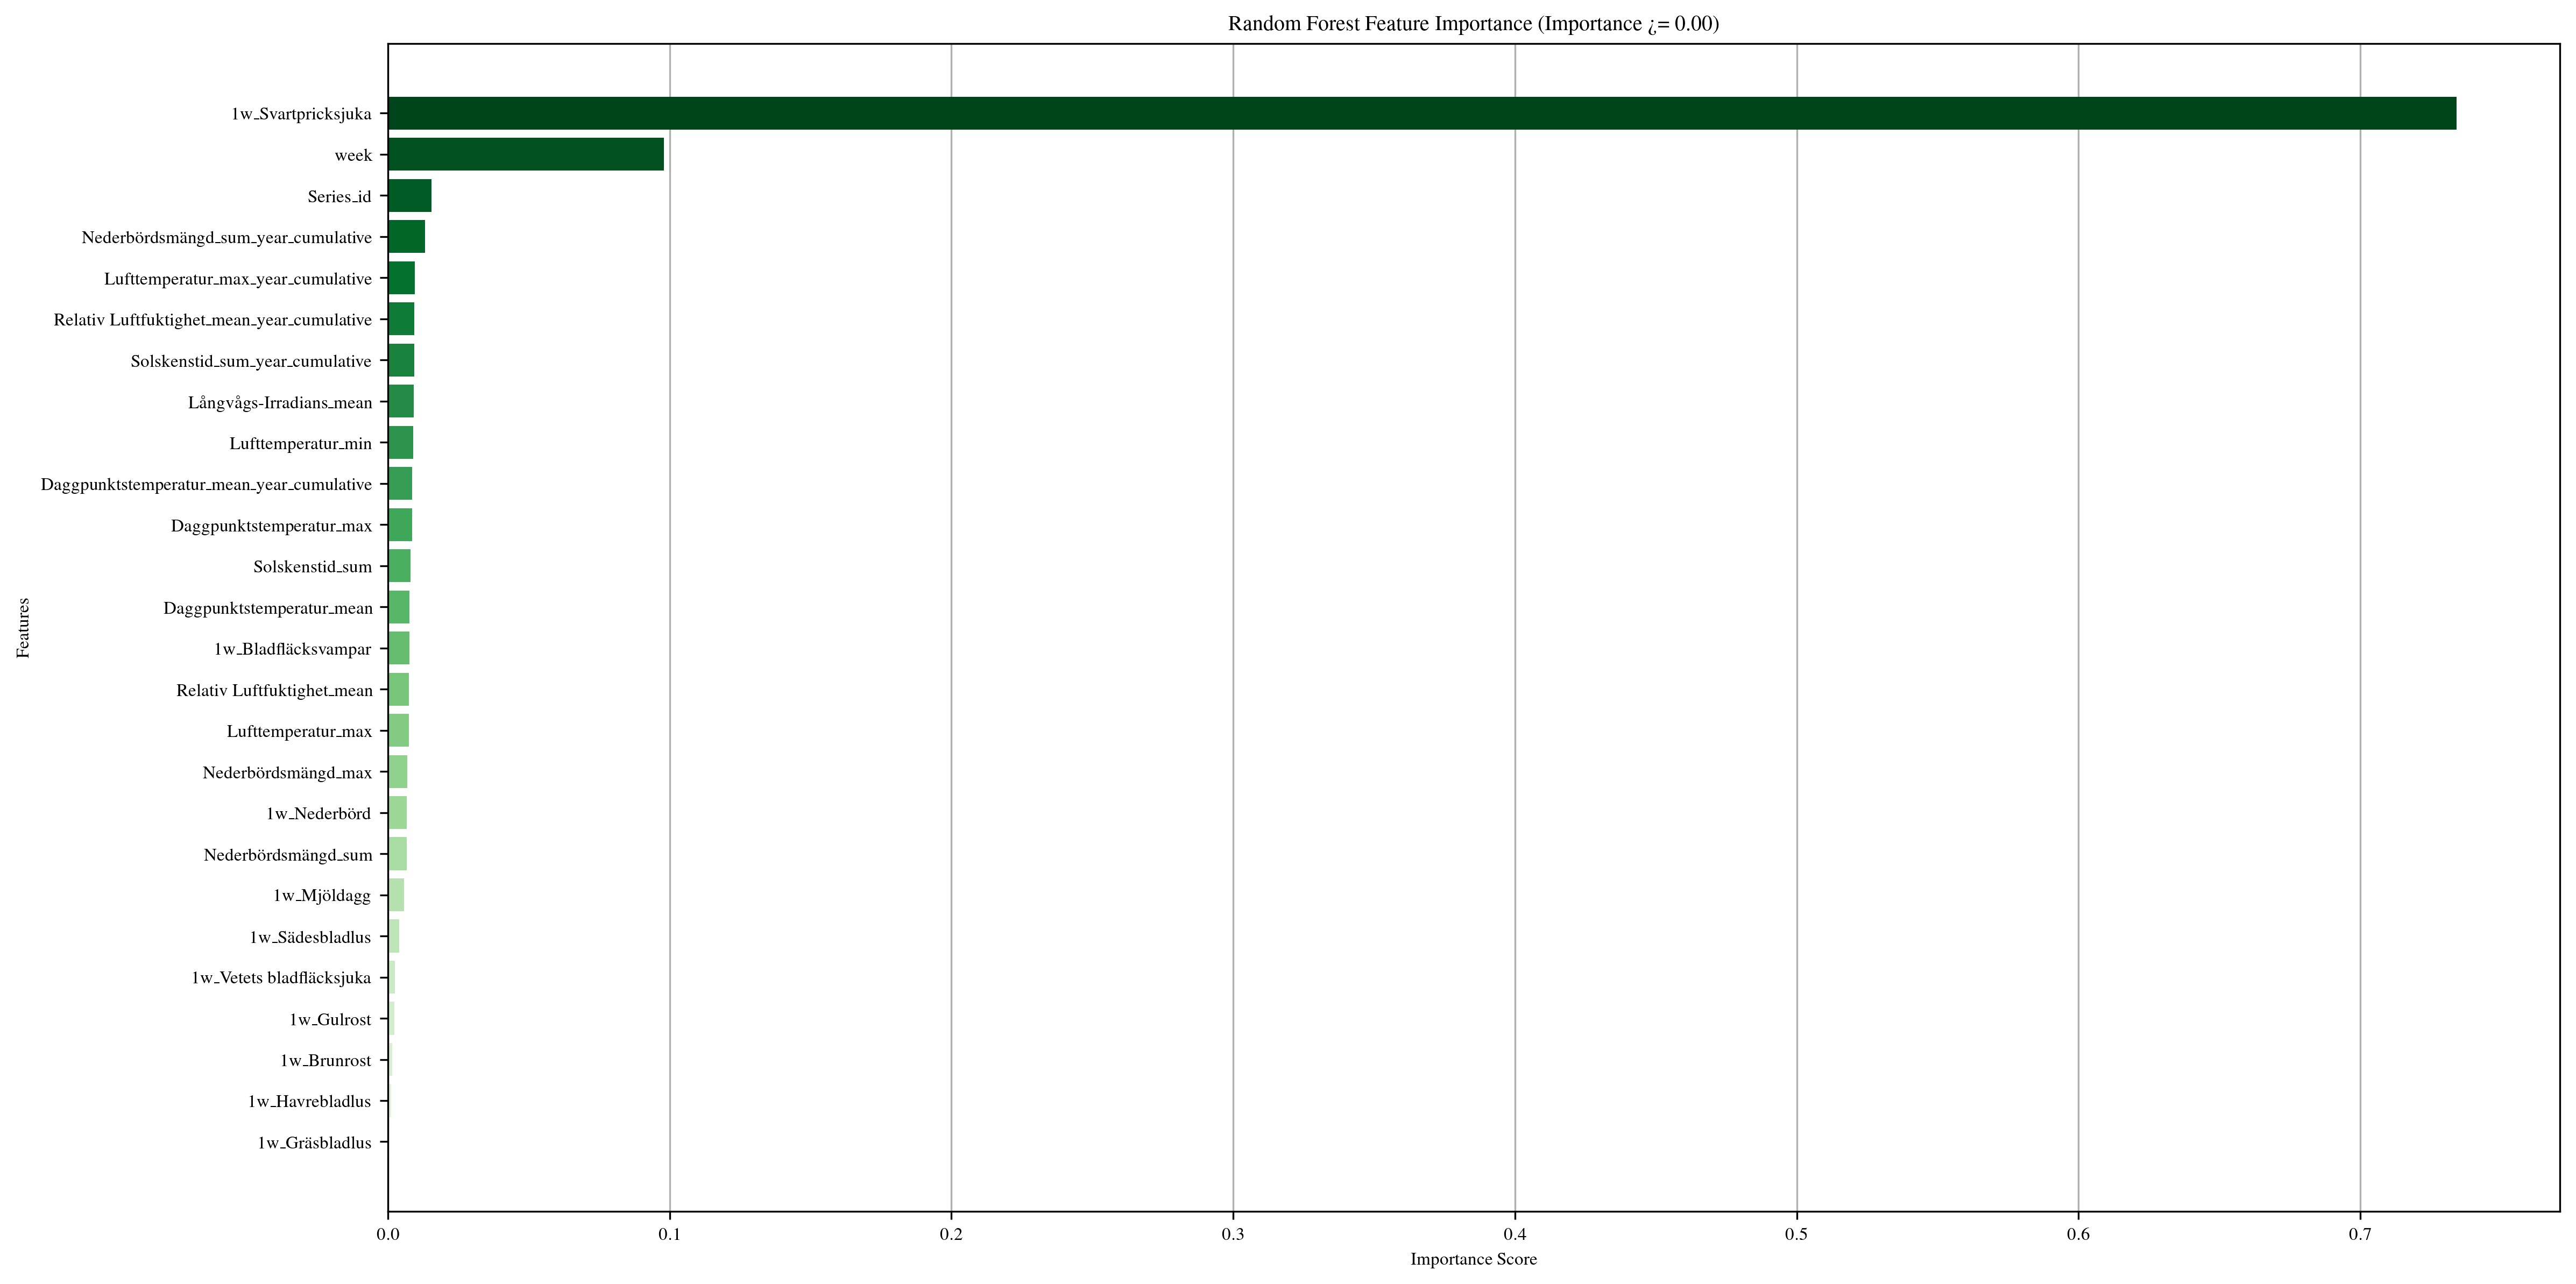

In [512]:
# 2. Feature Importance from Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_combined, y_combined.ravel())
rf_importances = rf_model.feature_importances_

rf_threshold = 0.0
rf_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
filtered_rf_importance_df = rf_importance_df[rf_importance_df['Importance'] >= rf_threshold].sort_values(by='Importance', ascending=True)

colors_rf = plt.cm.Greens(np.linspace(0.1, 1, len(filtered_rf_importance_df)))

plt.figure(figsize=(16, 8))
plt.barh(filtered_rf_importance_df['Feature'], filtered_rf_importance_df['Importance'], color=colors_rf, zorder=2)
plt.title('Random Forest Feature Importance (Importance >= {:.2f})'.format(rf_threshold))
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', ls='-', zorder=1)
plt.tight_layout()
plt.show()

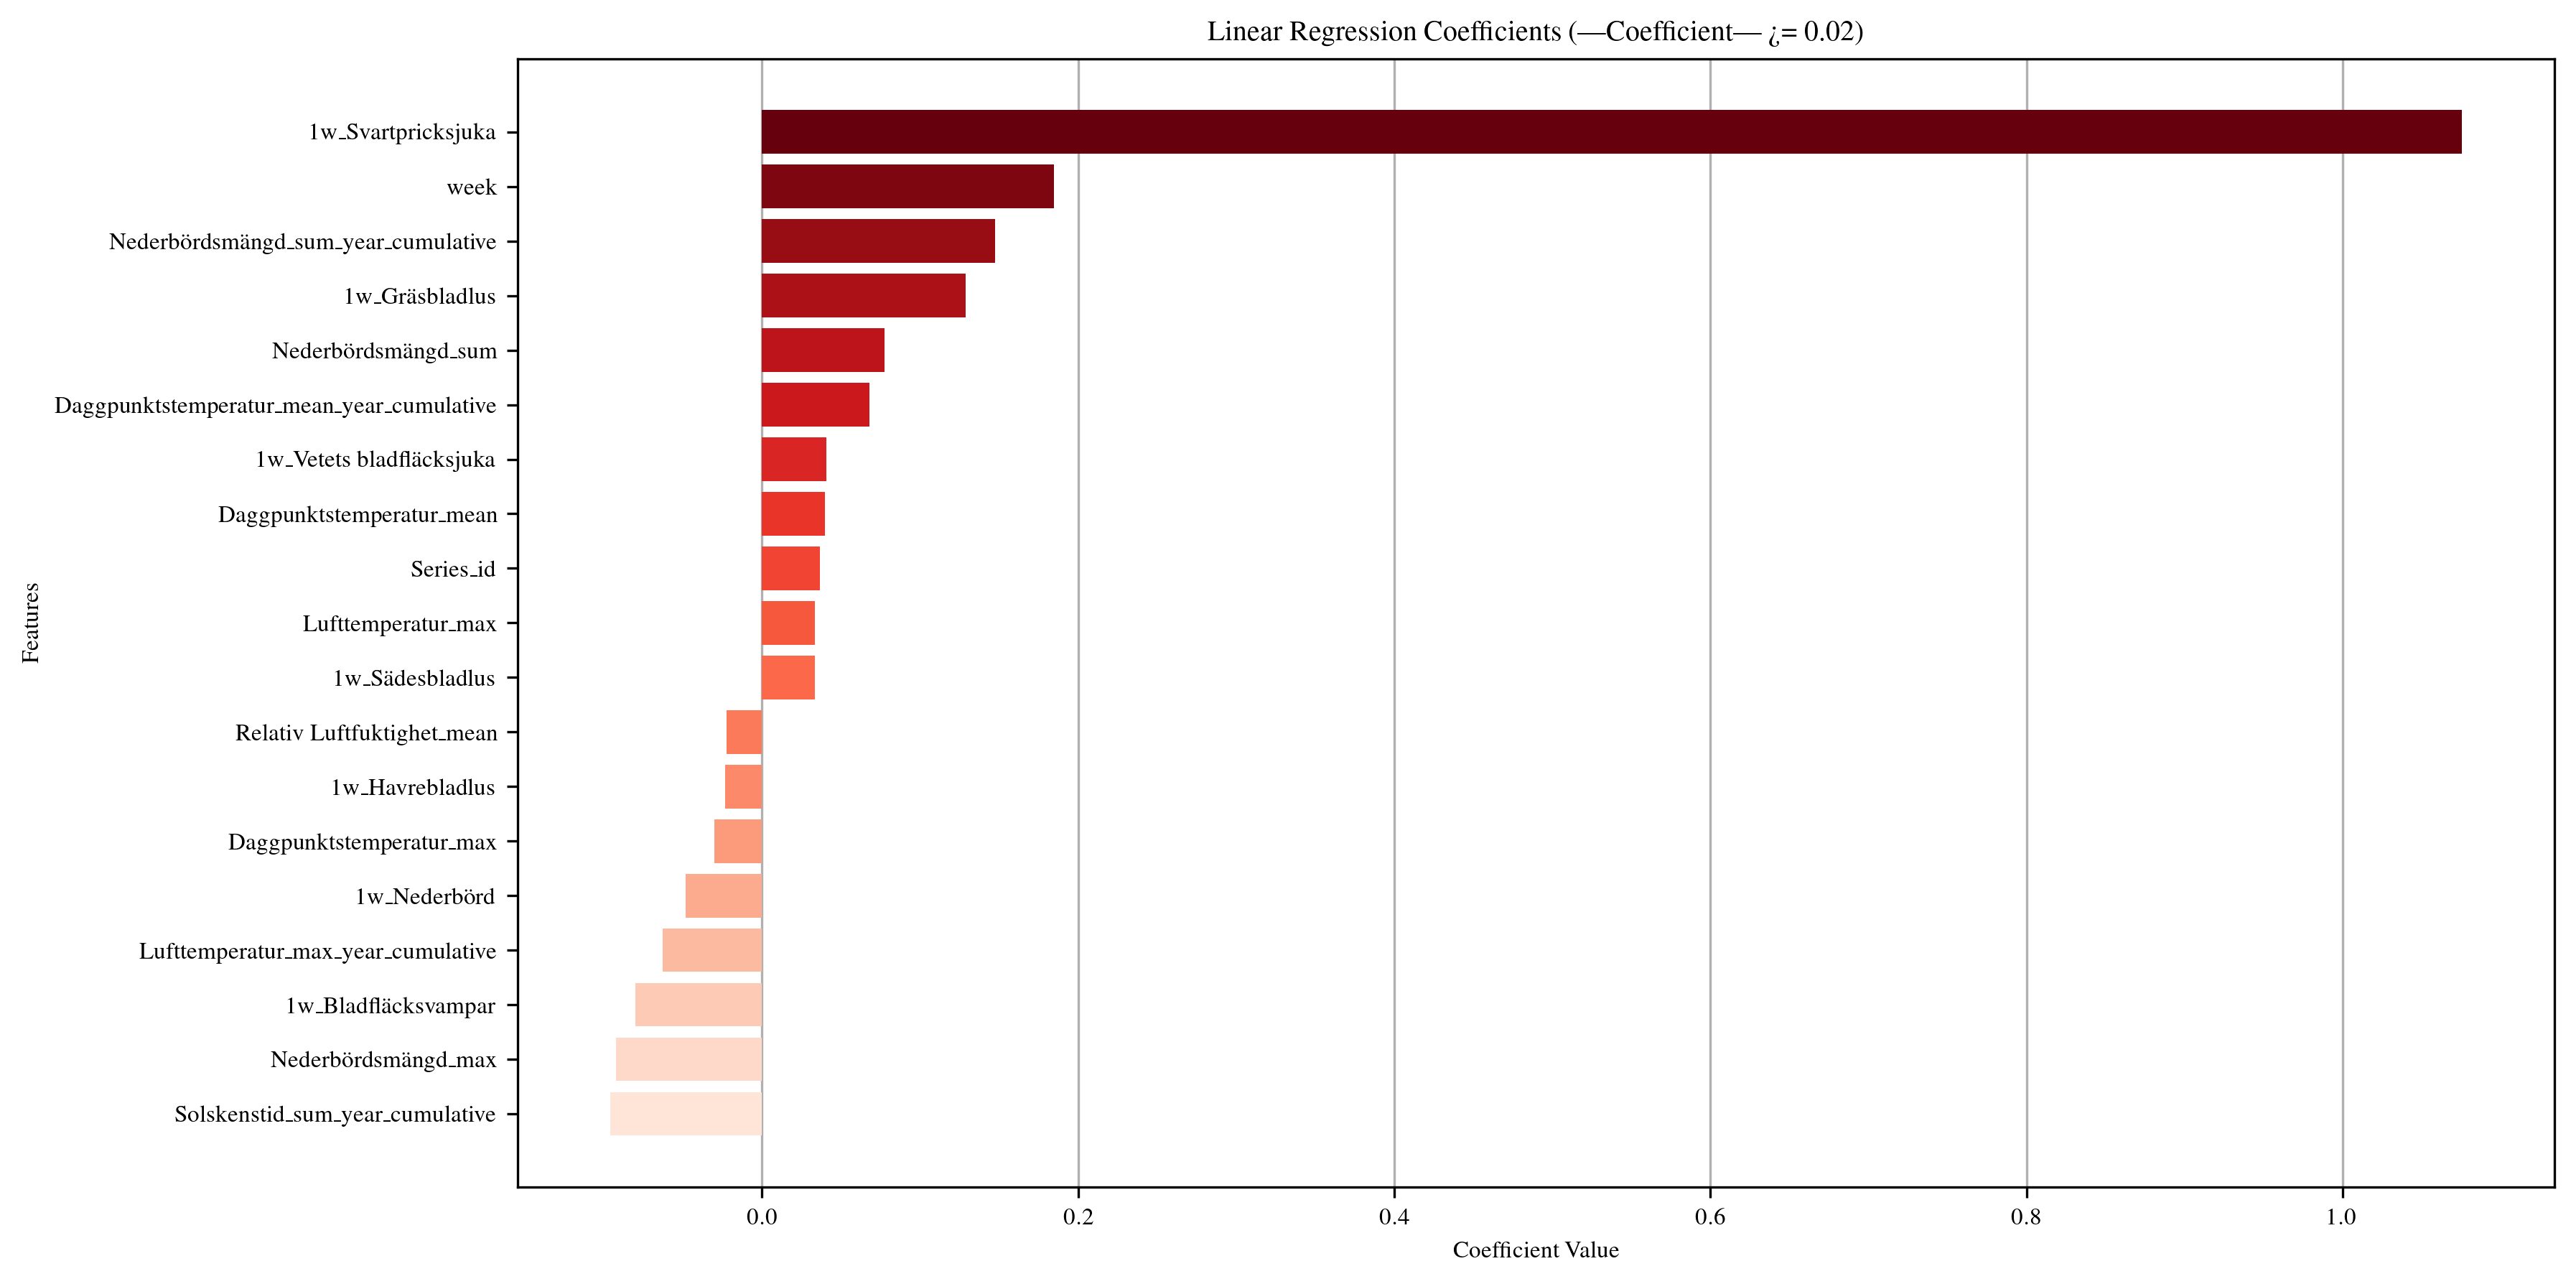

In [514]:
# 3. Regression Coefficients from Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_combined, y_combined)
lr_coefficients = lr_model.coef_.ravel()

lr_threshold = 0.02
lr_coefficient_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr_coefficients})
filtered_lr_coefficient_df = lr_coefficient_df[abs(lr_coefficient_df['Coefficient']) >= lr_threshold].sort_values(by='Coefficient', ascending=True)

colors_lr = plt.cm.Reds(np.linspace(0.1, 1, len(filtered_lr_coefficient_df)))

plt.figure(figsize=(12, 6))
plt.barh(filtered_lr_coefficient_df['Feature'], filtered_lr_coefficient_df['Coefficient'], color=colors_lr, zorder=2)
plt.title('Linear Regression Coefficients (|Coefficient| >= {:.2f})'.format(lr_threshold))
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.grid(axis='x', ls='-', zorder=1)
plt.tight_layout()
plt.show()

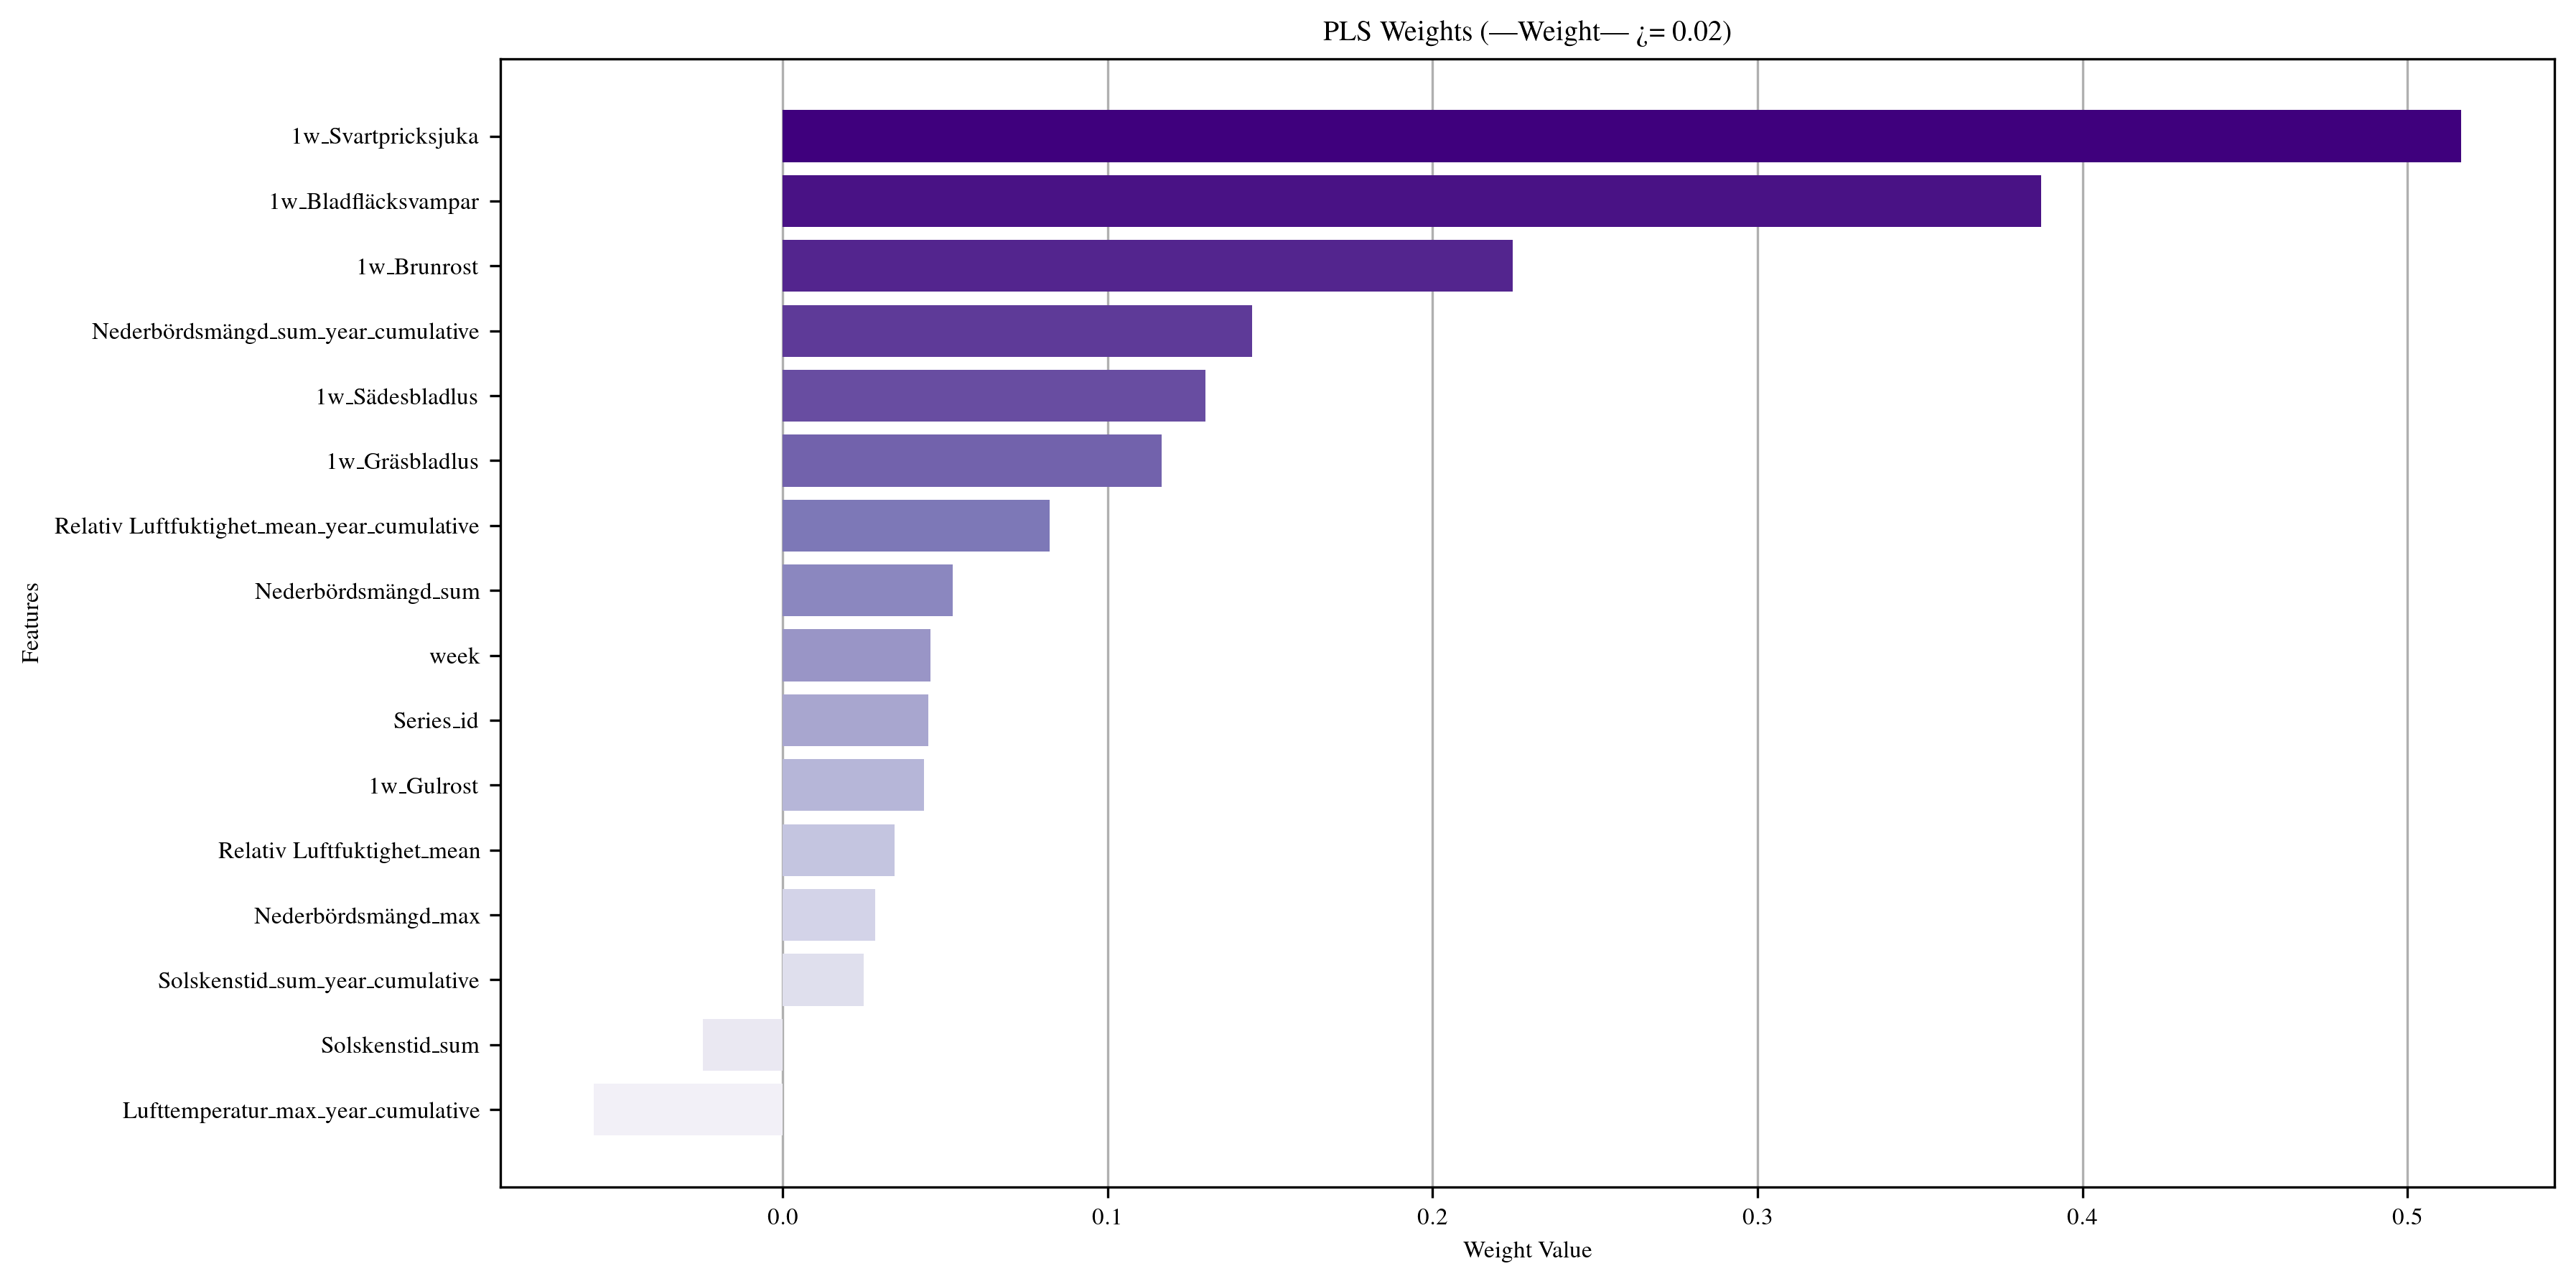

In [ ]:
# 4. Partial Least Squares Regression (PLS)
plt.rcdefaults()
pls_model = PLSRegression(n_components=2)
pls_model.fit(X_combined, y_combined)
pls_weights = pls_model.coef_

pls_threshold = 0.02
pls_weight_df = pd.DataFrame({'Feature': feature_names, 'Weight': pls_weights.flatten()})
filtered_pls_weight_df = pls_weight_df[abs(pls_weight_df['Weight']) >= pls_threshold].sort_values(by='Weight', ascending=True)

colors_pls = plt.cm.Purples(np.linspace(0.1, 1, len(filtered_pls_weight_df)))

plt.figure(figsize=(12, 6))
plt.barh(filtered_pls_weight_df['Feature'], filtered_pls_weight_df['Weight'], color=colors_pls, zorder=2)
plt.title('PLS Weights (|Weight| >= {:.2f})'.format(pls_threshold))
plt.xlabel('Weight Value')
plt.ylabel('Features')
plt.grid(axis='x', ls='-', zorder=1)
plt.tight_layout()
plt.show()

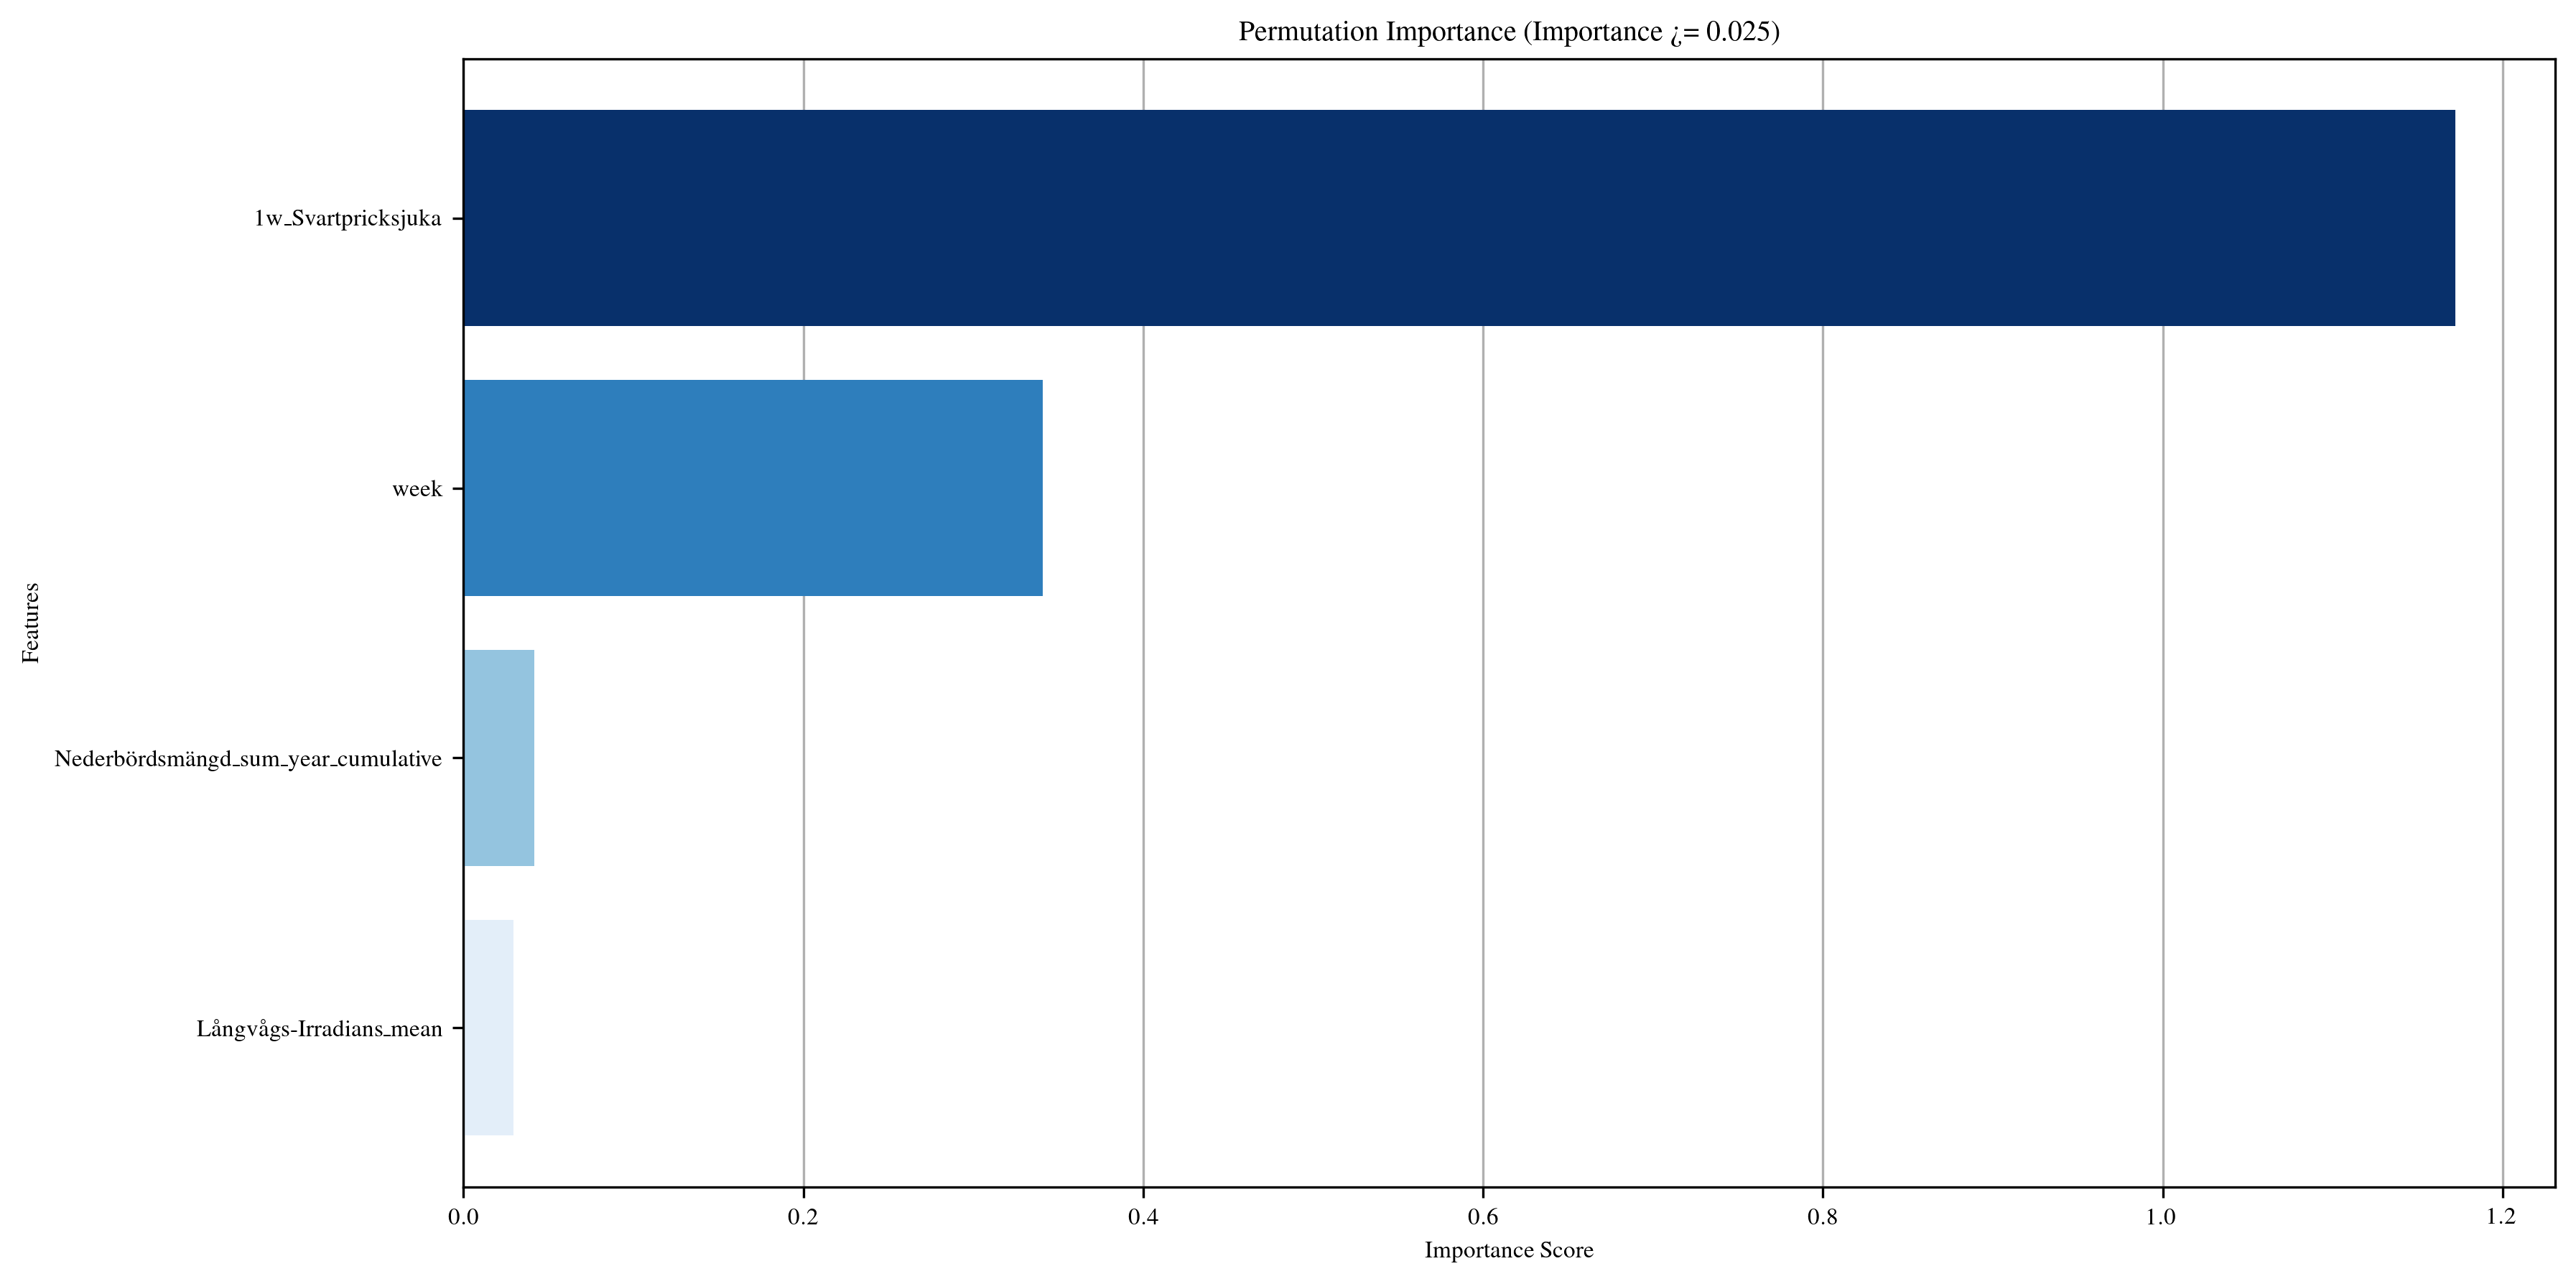

In [517]:
# 5. Permutation Importance
result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': result.importances_mean})

pi_threshold = 0.025
filtered_perm_importance_df = perm_importance_df[perm_importance_df['Importance'] >= pi_threshold].sort_values(by='Importance', ascending=True)

colors_perm = plt.cm.Blues(np.linspace(0.1, 1, len(filtered_perm_importance_df)))

plt.figure(figsize=(12, 6))
plt.barh(filtered_perm_importance_df['Feature'], filtered_perm_importance_df['Importance'], color=colors_perm, zorder=2)
plt.title('Permutation Importance (Importance >= {:.3f})'.format(pi_threshold))
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.grid(axis='x', ls='-', zorder=1)
plt.tight_layout()
plt.show()

# Log NN Perf. Based on Feature Analysis

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load your data
rows = 13016
batch_size = 32
epochs = 100
X_train = np.array(pd.read_csv('nn_data/reg/inn_40/X_train_n.csv').drop('Column0', axis=1).head(rows - (rows % batch_size)))
y_train = np.array(pd.read_csv('nn_data/reg/inn_40/y_train_n.csv').drop('Column0', axis=1).head(rows - (rows % batch_size)))
X_test = np.array(pd.read_csv('nn_data/reg/inn_40/X_test_n.csv').drop('Column0', axis=1))
y_test = np.array(pd.read_csv('nn_data/reg/inn_40/y_test_n.csv').drop('Column0', axis=1))

feature_names = pd.read_csv('nn_data/reg/inn_40/X_train_n.csv').drop('Column0', axis=1).columns.tolist()

features = X_train.shape[1]
layer_sizes = 3 * [2*features]
learning_rate = 0.0008
patience = 8
RUNS = 10

max_features = filtered_pls_weight_df  
average_r2_scores = []
previous_r2 = -np.inf  

log_file_path = 'nn_training_log.log'
with open(log_file_path, 'w') as log_file:
    # Log the settings of the neural network
    log_file.write("Neural Network Training Settings:\n")
    log_file.write(f"Input Features: {features}\n")
    log_file.write(f"Layer Sizes: {layer_sizes}\n")
    log_file.write(f"Learning Rate: {learning_rate}\n")
    log_file.write(f"Batch Size: {batch_size}\n")
    log_file.write(f"Epochs: {epochs}\n")
    log_file.write(f"Patience: {patience}\n")
    log_file.write(f"Runs/Combination: {RUNS}\n")
    log_file.write("\nAVERAGE R2 SCORES FOR EACH FEATURE COMBINATION:\n")

# Iterate through the top features
chunk_size = 1
for num_features in range(1, max_features + 1, chunk_size):
    # Select the top features based on mse_df_sorted
    selected_features_indices = mse_df_sorted.index[:num_features].tolist()
    selected_feature_names = [feature_names[idx] for idx in selected_features_indices]

    # Prepare the feature subsets
    X_train_subset = X_train[:, selected_features_indices]
    X_test_subset = X_test[:, selected_features_indices]
    
    r2_scores = []
    
    with open(log_file_path, 'a') as log_file:
        log_file.write(f'\n')
        log_file.write(f'-- FEATURES: {selected_feature_names} --\n')

    # Run the model 5 times and calculate the average R² score
    for run in range(RUNS):
        nn = NeuralNet(input_dim=num_features, output_dim=1, neurons=layer_sizes, 
                       loss_function='mse', activation_function='gelu', 
                       optimizer_type='adam', learning_rate=learning_rate)

        nn.train_net(X_train_subset, y_train, epochs=epochs, batch_size=batch_size, 
                     use_validation_data=True, patience=patience)
        
        activations = nn.forward(X_test_subset)
        
        r2 = r2_score(y_true=y_test, y_pred=activations)
        r2_scores.append(r2)
        with open(log_file_path, 'a') as log_file:
            log_file.write(f'Run {run+1}. Top {num_features} features. R2 {round(r2, 3)}.\n')
    
    average_r2 = np.mean(r2_scores)
    average_r2_scores.append(average_r2)
    
    with open(log_file_path, 'a') as log_file:
        log_file.write(f'Average R2 for top {num_features} features ({RUNS} runs): {round(average_r2, 3)}\n')
    
    if average_r2 <= previous_r2:
        with open(log_file_path, 'a') as log_file:
            log_file.write(f'\nStopping feature addition at {num_features - 1} features.')
        break
    
    previous_r2 = average_r2

with open(log_file_path, 'a') as log_file:
    log_file.write("\nAverage R2 scores for each feature count:")
    for i, score in enumerate(average_r2_scores):
        log_file.write(f'\nTop {i*chunk_size + 1} features: {round(score, 3)}')

KeyboardInterrupt: 